In [ ]:
%pip install mlxtend --upgrade
%pip install pyLDAvis
%pip install surprise
# %pip install tqdm
# %pip install ipywidgets
# %pip install plotly
# %pip install wordcloud


  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1626172 sha256=4c477b855c77ec7804546d80e2a2598ef2852d15a79268a301c88edd93750027
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# Imports

In [ ]:
import os
import pandas as pd
import numpy as np

from imblearn.over_sampling import ADASYN, SMOTE

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, concatenate,Embedding,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()

from mlxtend.plotting import plot_confusion_matrix as mlxcf

from sklearn.metrics import plot_confusion_matrix,classification_report, confusion_matrix ,multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer, normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import cohen_kappa_score

from sklearn.preprocessing import Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.cluster import KElbowVisualizer

import xgboost as xgb

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string


from gensim import matutils, models
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import gensim


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import plotly.express as px

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVDpp

from sklearn.decomposition import NMF as NMF_sklearn
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Read data and initialize variables

In [ ]:
RANDOM_STATE=0
movies_metadata="movies_metadata.csv"
ratings_small=""

In [ ]:
try:
    df = pd.read_csv("https://raw.githubusercontent.com/ahmed2m/DataScience-Applications-DTI5125/main/movies_metadata.csv?token=AGKLTOM3YUFXXKOB7L6VMSLBXWS24")
except:
    df = pd.read_csv(movies_metadata)

df=df.sample(len(df), random_state=RANDOM_STATE)

In [ ]:
columns_text=["original_title","overview","tagline"]

columns_to_use=["adult","budget","original_language","popularity",
                "revenue","vote_average","vote_count"]
column_target=["genres_list","genre_hot_encoded"]

In [ ]:
# column encoder
def encoder(column_df):
    enc = LabelEncoder()
    return enc.fit_transform(df[column_df]), enc.classes_

In [ ]:
# onehotencoding method #2 for list(dict) column types
def one_hot_dict_converter(column_df):
    global df
    tmp_column_list=[]
    index_del=[]
    for index, i in enumerate(df[column_df]):
        tmp=[]
        try:
            for j in eval(i):
                tmp.append(j["name"])
        except:
            index_del.append(index)
            print(f"error in {index} {i} {j}")
        tmp_column_list.append(tmp)

    # check record length , and delete record from dataframe is there is error and the updated 
    # multilabelBinarizers will retrun each to the adjacent correct index number
    df=df.drop(df.index[index_del])
    df.reset_index(drop=True,inplace=True)
    
    mlb = MultiLabelBinarizer()
    new_features = mlb.fit_transform(tmp_column_list)
    return new_features

In [ ]:
def clean_text(text):
    '''
    - Make text lowercase
    - Remove text in square brackets
    - Remove punctuation
    - Remove words containing numbers
    - Match words only not in stop words
    - Remove empty strings
    - Get rid of some additional punctuation
    - Get rid of some non-sensical text
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text_words = list(filter(lambda x: x not in stopwords.words("english"), re.findall("[\w]*", text)))
    text_words = list(filter(lambda x: x != '', text_words)) # I think this is line is doing nothing @ansary check and delete plz XD
    text = ' '.join(text_words)
    return text

# Data preprocessing

In [ ]:
# remove extra wrong records in adult and original language columns
df = df.loc[df["adult"].isin(["True","False"])]
df = df[df["original_language"].notna()]

#generating list of genres per record and replace empty genres with empty string
final_genre_list=[]
for i in df["genres"]:
    tmp=[]
    for j in eval(i):
        tmp.append(j["name"])
    final_genre_list.append(tmp)

df["genres_list"]=final_genre_list
df["genres_list"].replace({"[]": ""}, inplace=True)

df.reset_index(drop=True,inplace=True)

In [ ]:
#unique genres
unique_genres=np.unique(list(np.concatenate(final_genre_list).flat))

In [ ]:
# one_hot_encoder for final_genre_list 
hot_encoded_genres=[]
enc = LabelEncoder()
enc.fit(unique_genres)

for i in final_genre_list:
    letters= [0 for _ in range(len(unique_genres))]
    for j in enc.transform(i):
        letters[j]=1
    hot_encoded_genres.append(letters)

df["genre_hot_encoded"]=hot_encoded_genres

In [ ]:
df["adult"], _= encoder("adult")
df["original_language"], original_language_classes = encoder("original_language")

In [ ]:
X = df.loc[:,columns_to_use+columns_text+column_target]
del df

In [ ]:
# encoding genres list to 0,1,2,3,..4064
genre_list_enc = LabelEncoder()
X["genres_list_encoded"]=genre_list_enc.fit_transform(X["genres_list"].astype(str))

In [ ]:
X["genres_list_tupled"] = list(tuple(sorted(x)) for x in X["genres_list"])
X=X[X["genres_list_tupled"]!=()]

In [ ]:
X= X[X['overview'].notna()]
X["tagline"]=X["tagline"].replace(np.NAN,"")

# load the last cleaned overiew data as it take too much time , we didn't remove notna above it for length consistency , it should be the same as saved before
try:
  X["overview"]=pd.read_csv("overview.csv")["overview"]
except:
  print("creating new csv file for overview column")
  X["overview"]=X["overview"].apply(lambda x:clean_text(x))
  X["overview"].to_csv("overview.csv")

creating new csv file for overview column


In [ ]:
genre_tupled_sorted=pd.DataFrame([
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[0]),
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[1])
                                  ]).T.sort_values(by=1, ascending=False)
genre_tupled_sorted=genre_tupled_sorted.rename(columns={0: "genre_tuples", 1: "count"})
genre_tupled_sorted

genre_tuples count
1528                                           (Drama,)  4910
1082                                          (Comedy,)  3371
1468                                     (Documentary,)  2682
1709                                   (Drama, Romance)  1627
1150                                    (Comedy, Drama)  1619
...                                                 ...   ...
829   (Adventure, Drama, Family, Science Fiction, TV...     1
827                 (Adventure, Drama, Family, Romance)     1
825                 (Adventure, Drama, Family, Foreign)     1
824       (Adventure, Drama, Family, Fantasy, Thriller)     1
955   (Animation, Comedy, Drama, Horror, Mystery, Ro...     1

[1910 rows x 2 columns]

In [ ]:
X.reset_index(inplace=True,drop=True)

In [ ]:
X= X[X["popularity"].notna()]
X= X[X["vote_count"].notna()]
X= X[X["revenue"].notna()]

In [ ]:
X=X.astype({'budget': 'int32','popularity': 'float32','vote_count':'int32','revenue': 'int32'})

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42312 entries, 0 to 42314
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   adult                42312 non-null  int64  
 1   budget               42312 non-null  int32  
 2   original_language    42312 non-null  int64  
 3   popularity           42312 non-null  float32
 4   revenue              42312 non-null  int32  
 5   vote_average         42312 non-null  float64
 6   vote_count           42312 non-null  int32  
 7   original_title       42312 non-null  object 
 8   overview             42312 non-null  object 
 9   tagline              42312 non-null  object 
 10  genres_list          42312 non-null  object 
 11  genre_hot_encoded    42312 non-null  object 
 12  genres_list_encoded  42312 non-null  int64  
 13  genres_list_tupled   42312 non-null  object 
dtypes: float32(1), float64(1), int32(3), int64(3), object(6)
memory usage: 4.2+ MB


In [ ]:
X.describe()

adult        budget  ...    vote_count  genres_list_encoded
count  42312.000000  4.231200e+04  ...  42312.000000         42312.000000
mean       0.000213  4.532266e+06  ...    117.727359          2011.555989
std        0.014583  1.802132e+07  ...    508.372330           927.599828
min        0.000000  0.000000e+00  ...      0.000000             0.000000
25%        0.000000  0.000000e+00  ...      4.000000          1507.000000
50%        0.000000  0.000000e+00  ...     11.000000          1935.000000
75%        0.000000  0.000000e+00  ...     38.000000          2383.000000
max        1.000000  3.800000e+08  ...  14075.000000          4063.000000

[8 rows x 8 columns]

In [ ]:
# updating revenue column to make it all positive as there is cells with negative vaue which is not realsitic
X["revenue"]=X["revenue"].apply(lambda x:abs(x))

In [ ]:
X["tagline"]=X["tagline"].apply(lambda x:clean_text(x))

X["text_concat"]=X["original_title"]+" "+X["overview"]+" "+X["tagline"]
X=X[X["text_concat"].notna()]

# visulaizations

#### As we see below we have imbalance classes


In [ ]:
top=80

Total count of unqiue tupled genres is : 1910


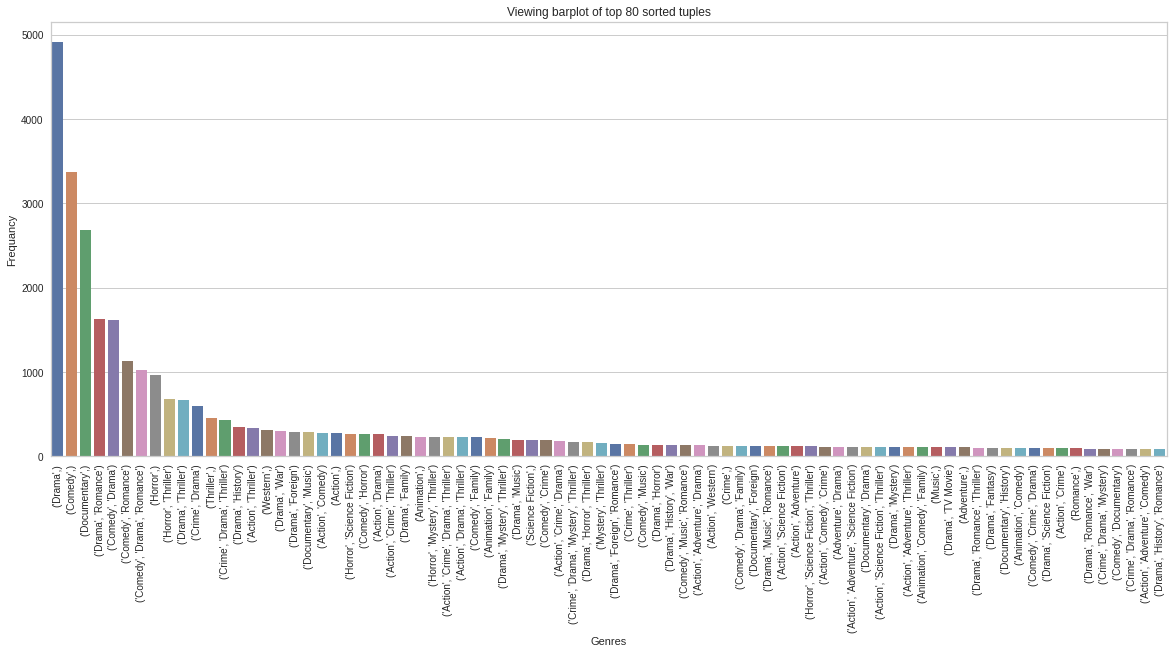

In [ ]:
# top genre tupled histogram
print("Total count of unqiue tupled genres is :",len(genre_tupled_sorted))


plt.figure(figsize=(20,8))
plt.title(f"Viewing barplot of top {top} sorted tuples")
plt.xticks(rotation=90)
ax = sns.barplot(x="genre_tuples", y="count", data=genre_tupled_sorted.iloc[0:top,:],palette="deep")
ax.set(xlabel='Genres', ylabel='Frequancy')
plt.show()

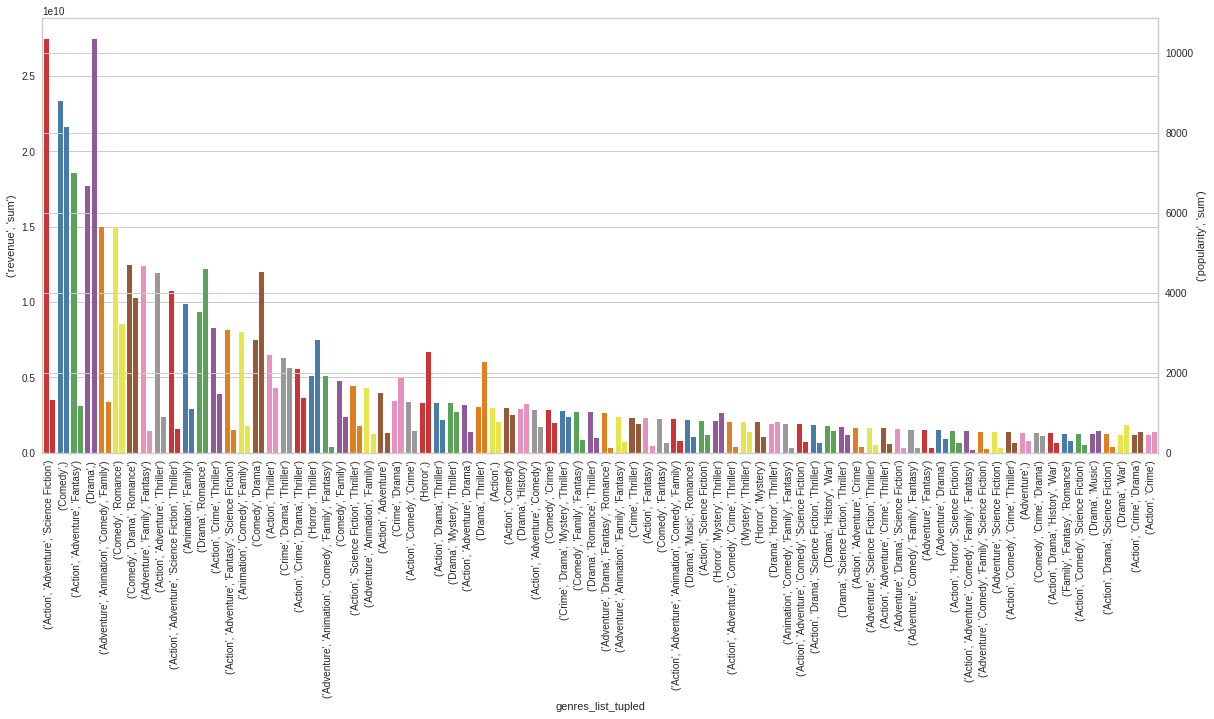

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.xticks(rotation=90)


ax = sns.barplot(x="genres_list_tupled", y=("revenue","sum"),
            data=X.groupby(['genres_list_tupled'])["revenue","popularity"]
                    .agg({"revenue":["sum"],"popularity":["sum"]})
                    .reset_index()
                    .sort_values(by=("revenue","sum"),ascending=False)
                    .iloc[0:top,:],
            palette="Set1")

ax2 = ax.twinx()
g2 = sns.barplot(x="genres_list_tupled", y=("popularity","sum"),
            data=X.groupby(['genres_list_tupled'])["revenue","popularity"]
                    .agg({"revenue":["sum"],"popularity":["sum"]})
                    .reset_index()
                    .sort_values(by=("revenue","sum"),ascending=False)
                    .iloc[0:top,:],
            palette="Set1",ax=ax2)

width_scale = 0.45
for bar in ax.containers[0]:
    bar.set_width(bar.get_width() * width_scale)


for bar in ax2.containers[0]:
    x = bar.get_x()
    w = bar.get_width()
    bar.set_x(x + w * (1- width_scale))
    bar.set_width(w * width_scale)

plt.show()


#ax.set(xlabel='Genres', ylabel='Revenue in billion')
#plt.show()

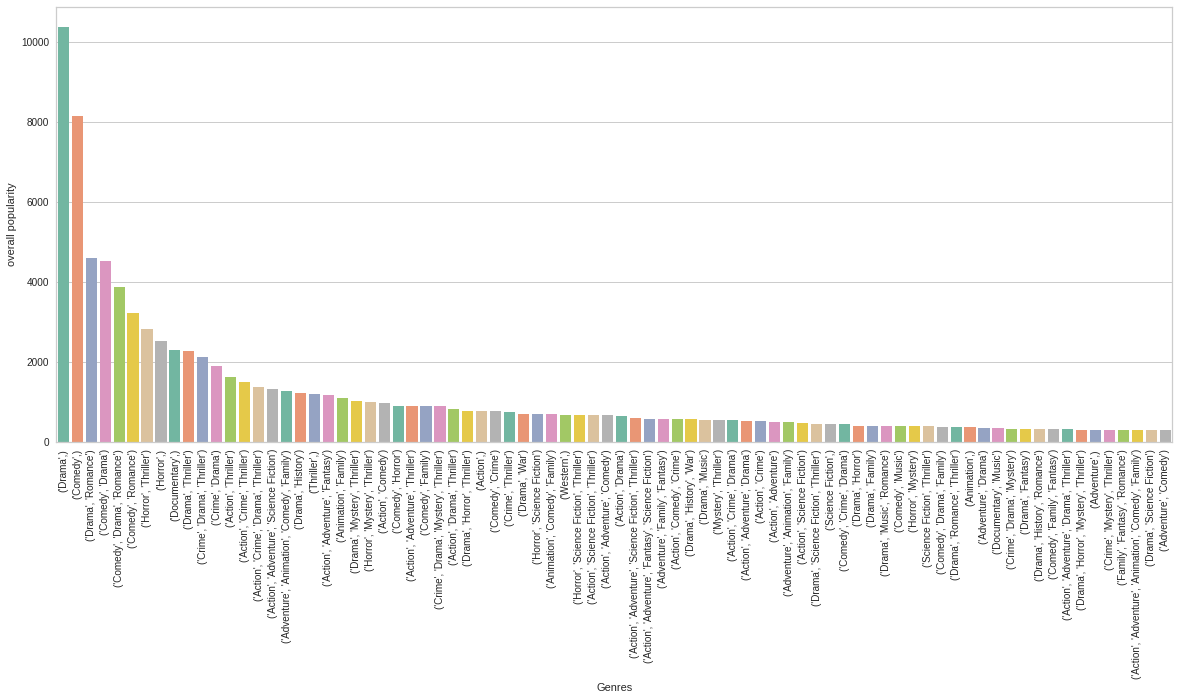

In [ ]:
# genre vs overall popularity
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="genres_list_tupled", y="sum",
            data=X.groupby(['genres_list_tupled'])["popularity"]
            .agg(['sum'])
            .reset_index()
            .sort_values(by="sum",ascending=False).iloc[0:top,:],palette="Set2")

ax.set(xlabel='Genres', ylabel='overall popularity')
plt.show()

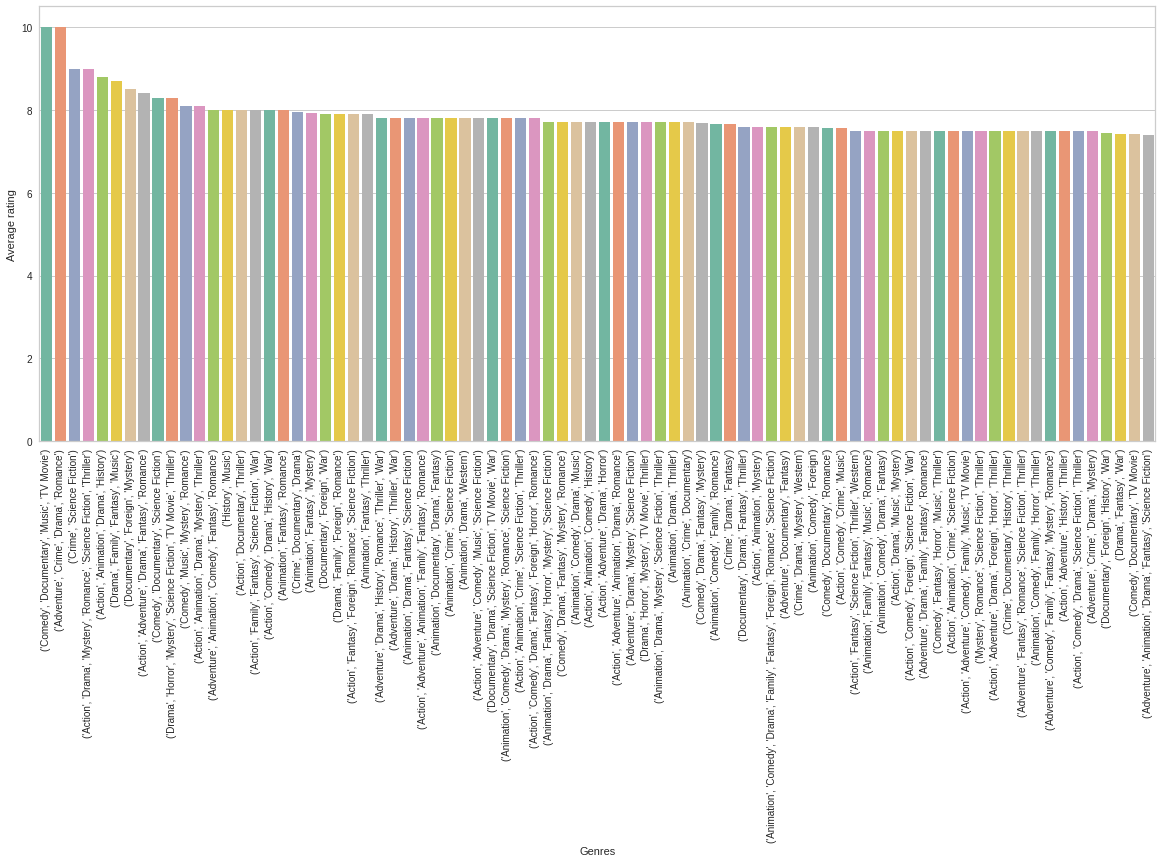

In [ ]:
# here we only got avergae rating vs genres without taking into consideration
# number of voters as we see in next cell the one with rating 10.0 has only one voter
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="genres_list_tupled", y=("vote_average","mean"),
            data=X.groupby(['genres_list_tupled'])["vote_average","vote_count"].agg(['mean',"sum"]).reset_index().sort_values(by=("vote_average","mean"),ascending=False).iloc[0:top,:],palette="Set2")

ax.set(xlabel='Genres', ylabel='Average rating')
plt.show()

In [ ]:
# only one voter as we see from the data
print("('Comedy','Documentary','Music','TV Movie') has only",len(X[X["genres_list_tupled"]==('Comedy','Documentary','Music','TV Movie')]),"vote/s")

print("('Adventure','Crime','Drama','Romance') has only",len(X[X["genres_list_tupled"]==('Adventure','Crime','Drama','Romance')]),"vote/s")

('Comedy','Documentary','Music','TV Movie') has only 1 vote/s
('Adventure','Crime','Drama','Romance') has only 1 vote/s


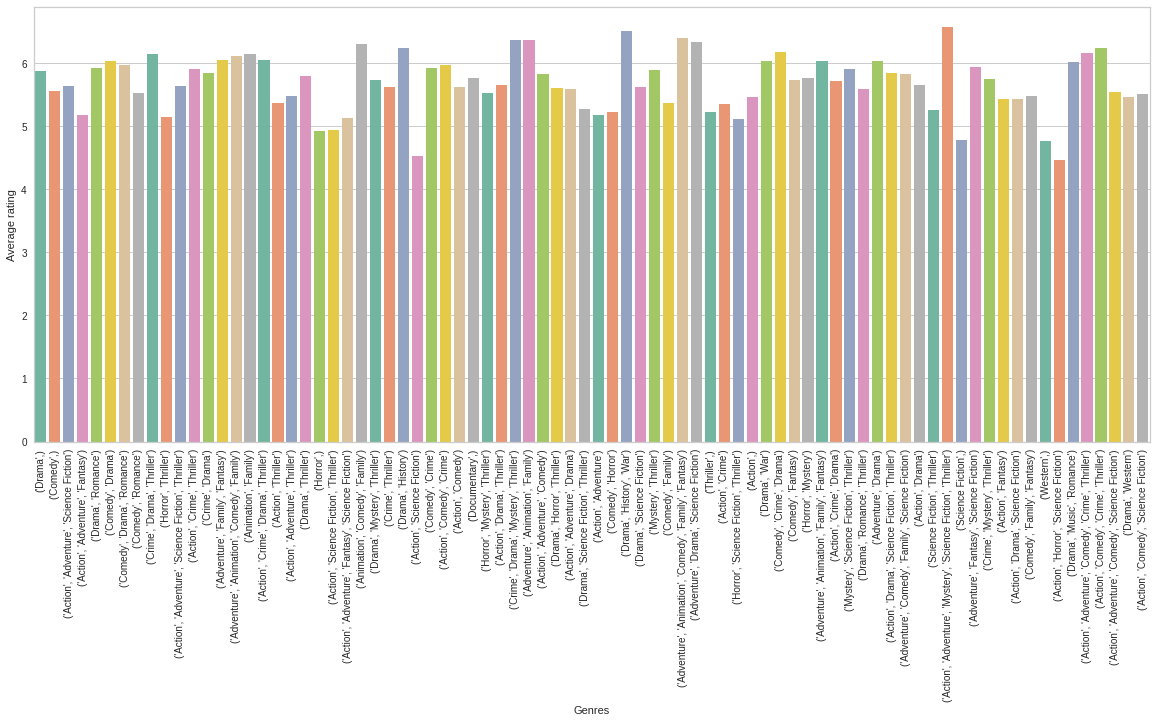

In [ ]:
# here we plotted Genres vs average voting sorted with number of voters
plt.figure(figsize=(20,8))
plt.xticks(rotation=90)

ax = sns.barplot(x="genres_list_tupled", y=('vote_average', 'mean'),
            data=X.groupby(['genres_list_tupled'],as_index=False)["vote_average","vote_count"]
            .agg({'vote_average' : ['mean'], 'vote_count' : ['sum']})
            .sort_values([('vote_count',  'sum'),('vote_average', 'mean')],ascending=False)
            .iloc[0:top,:]
            ,palette="Set2")


ax.set(xlabel='Genres', ylabel='Average rating')
plt.show()

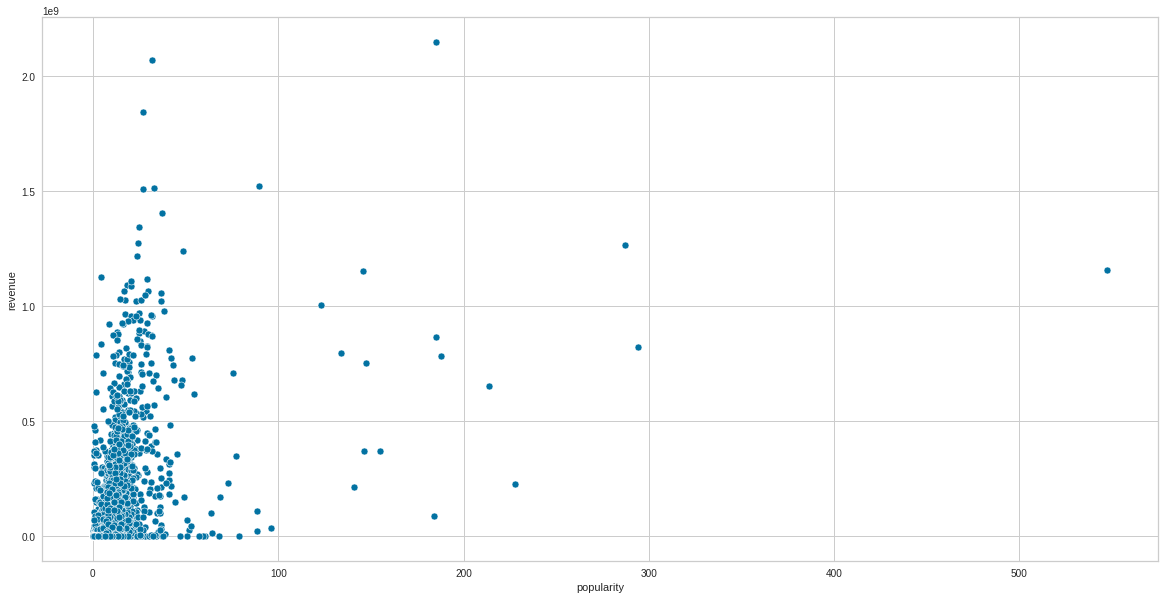

In [ ]:
# popularity vs revenue
plt.figure(figsize=(20,10))
sns.scatterplot(data=X, x="popularity", y="revenue")

In [ ]:
# data preparation -> new column for average votes for next visyalzation (vote_count vs revenue vs vote_average)
X["vote_average_categorical"]=X["vote_average"].apply(lambda x: "Good" if x>7 else "Bad")

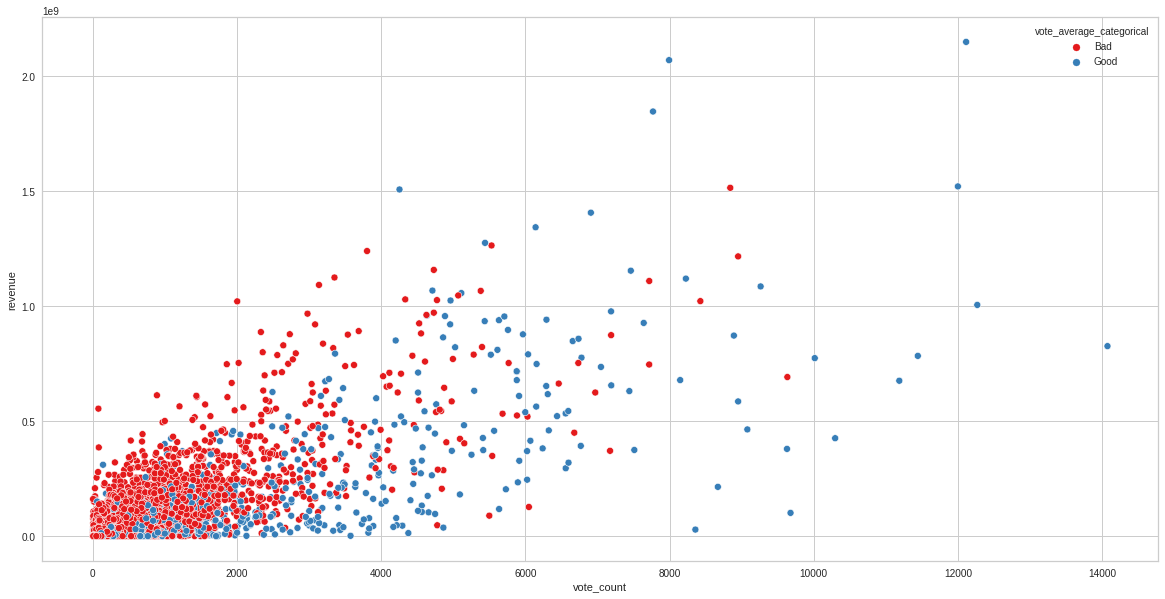

In [ ]:
# vote_count vs revenue
plt.figure(figsize=(20,10))
sns.scatterplot(data=X, x="vote_count", y="revenue",hue="vote_average_categorical",palette="Set1")

In [ ]:
# most common genre across all dataset

from collections import Counter

words = X["genres_list"].to_list()
counter = Counter(words[0])
for i in words[1:]: 
    counter.update(i)

counter.most_common()

[('Drama', 20020),
 ('Comedy', 12805),
 ('Thriller', 7585),
 ('Romance', 6672),
 ('Action', 6562),
 ('Horror', 4659),
 ('Crime', 4269),
 ('Documentary', 3882),
 ('Adventure', 3470),
 ('Science Fiction', 3026),
 ('Family', 2732),
 ('Mystery', 2451),
 ('Fantasy', 2290),
 ('Animation', 1917),
 ('Foreign', 1599),
 ('Music', 1588),
 ('History', 1378),
 ('War', 1308),
 ('Western', 1034),
 ('TV Movie', 750)]

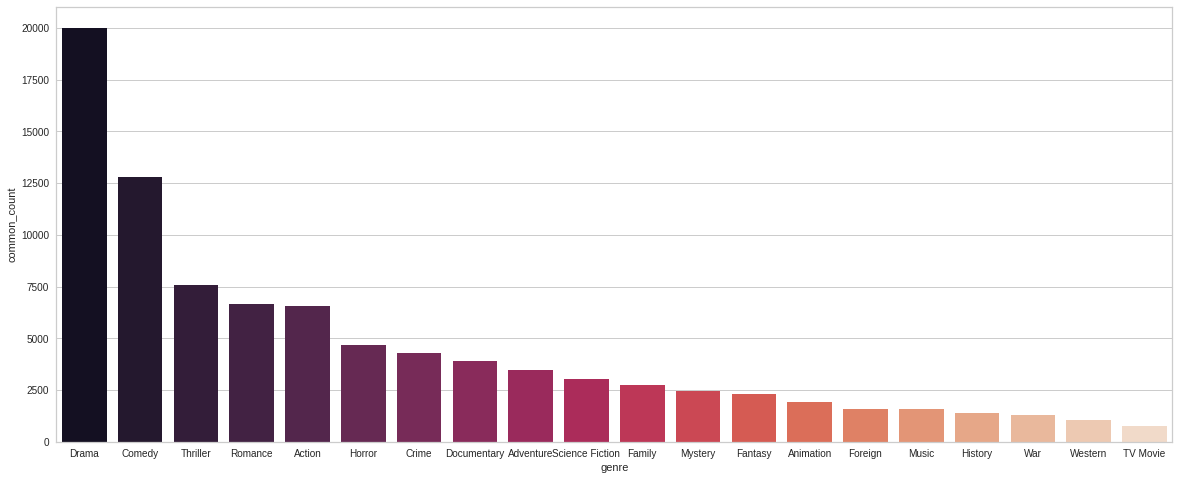

In [ ]:
# most common genre in all the dataset
plt.figure(figsize=(20,8))

sns.barplot(data=pd.DataFrame(counter.most_common()).rename(columns={0:"genre",1:"common_count"}),
            x="genre",y="common_count",palette="rocket")


In [ ]:
numeric_columns=[]
for i in X.columns:
    if "int" in str(X[i].dtype) or "float" in str(X[i].dtype):
        numeric_columns.append(i)
numeric_columns=numeric_columns[1:]

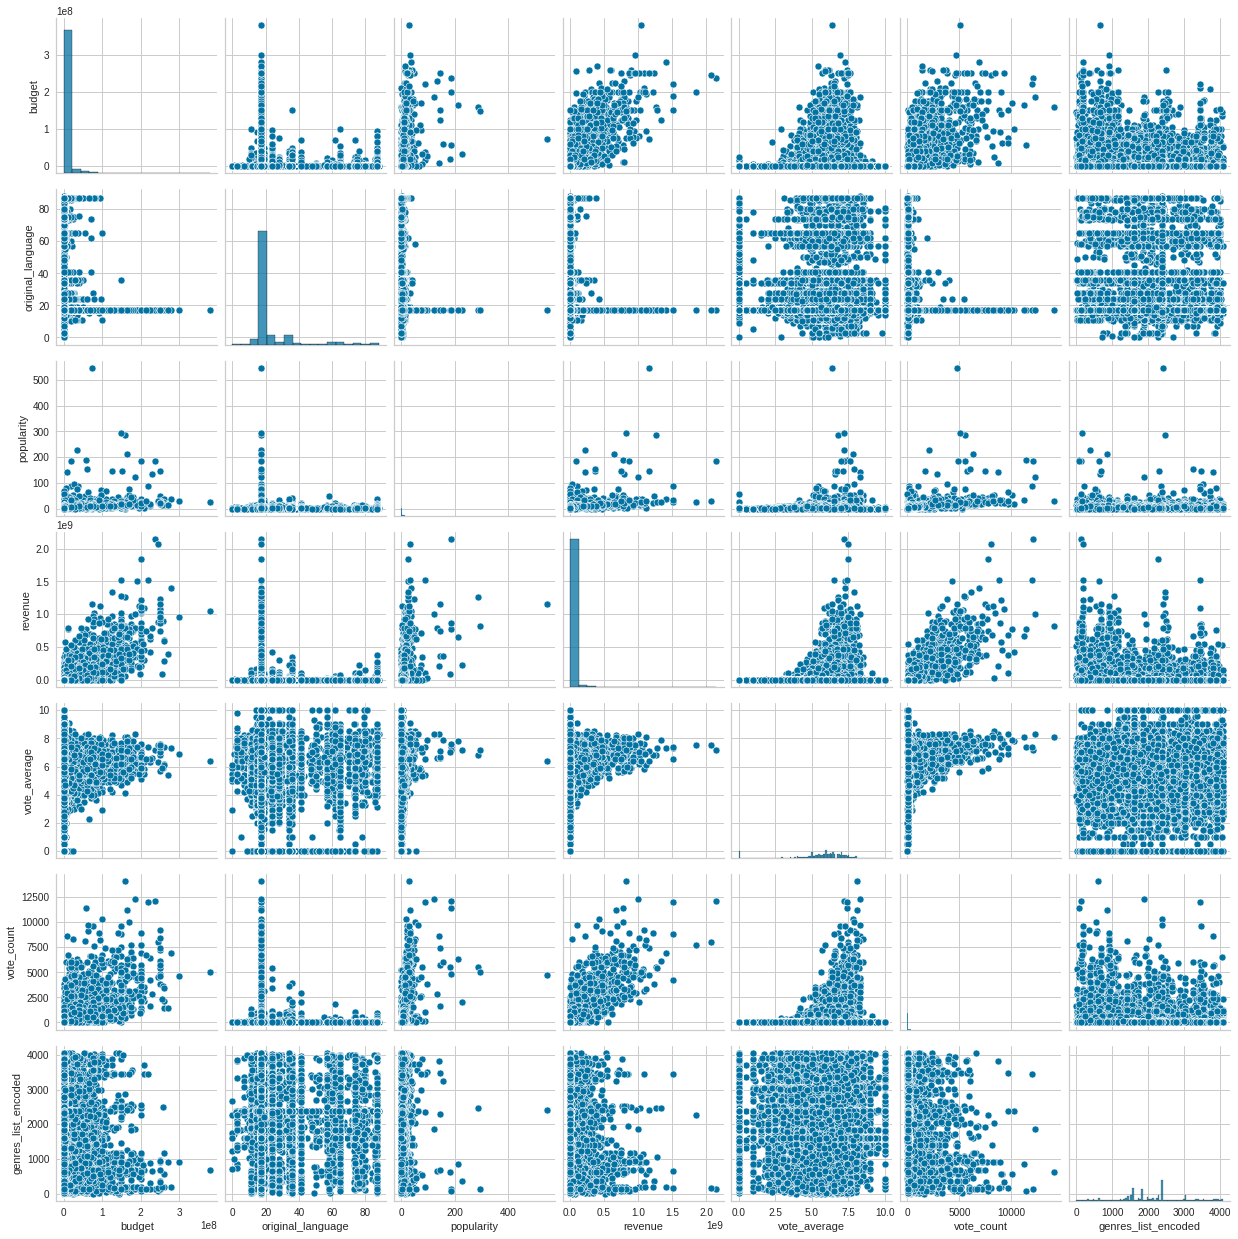

In [ ]:
# heatmap
sns.pairplot(X.loc[:,numeric_columns])
plt.show()

In [ ]:
# Heatmap corr attempt

# plt.figure(figsize=(20,8))
# sns.heatmap(X.loc[:,numeric_columns])

In [ ]:
X_full = X.copy()
# remove minor classes with certain threshold to make data more balanced
X=X[X["genres_list_tupled"].isin(list(genre_tupled_sorted.iloc[:7,:]["genre_tuples"].values))]
X.reset_index(inplace=True, drop=True)
len(X), len(X_full)

(16362, 42312)

In [ ]:
genre_tupled_sorted=pd.DataFrame([
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[0]),
                                  list(np.unique(np.array(X["genres_list_tupled"]),return_counts=True)[1])
                                  ]).T.sort_values(by=1, ascending=False)
genre_tupled_sorted=genre_tupled_sorted.rename(columns={0: "genre_tuples", 1: "count"})
genre_tupled_sorted

genre_tuples count
5                  (Drama,)  4910
0                 (Comedy,)  3371
4            (Documentary,)  2682
6          (Drama, Romance)  1627
1           (Comedy, Drama)  1619
3         (Comedy, Romance)  1128
2  (Comedy, Drama, Romance)  1025

Total count of unqiue tupled genres is : 7


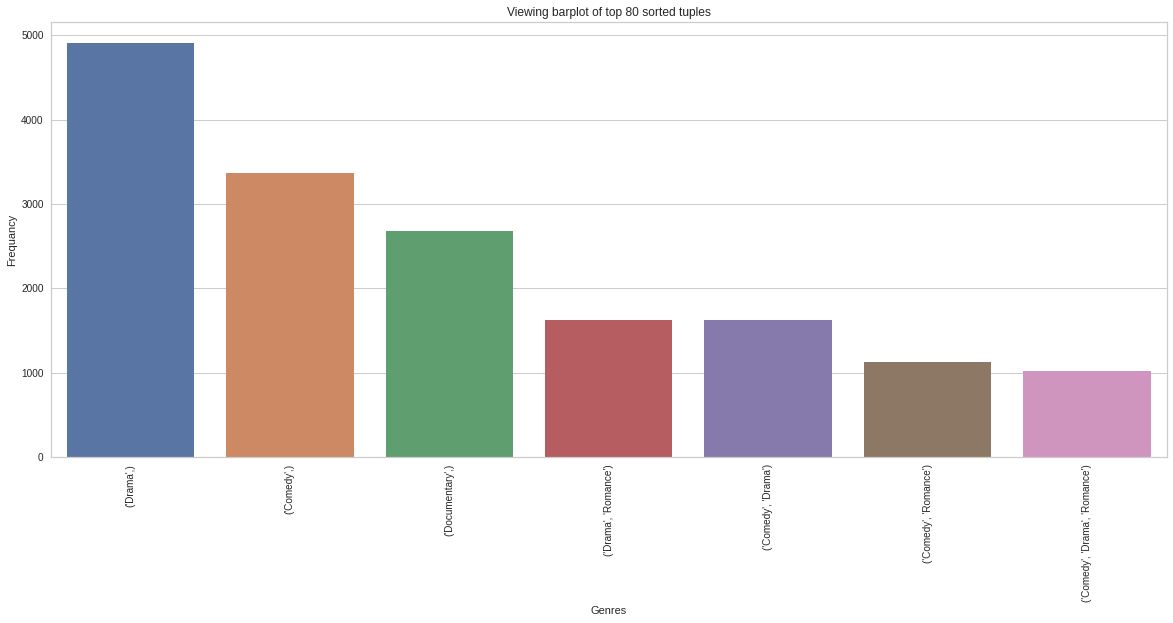

In [ ]:
# top genre tupled histogram AFTER threshold
print("Total count of unqiue tupled genres is :",len(genre_tupled_sorted))


plt.figure(figsize=(20,8))
plt.title(f"Viewing barplot of top {top} sorted tuples")
plt.xticks(rotation=90)
ax = sns.barplot(x="genre_tuples", y="count", data=genre_tupled_sorted.iloc[0:top,:],palette="deep")
ax.set(xlabel='Genres', ylabel='Frequancy')
plt.show()

In [ ]:
#generating list of genres per record and replace empty genres with empty string
final_genre_list=[]
for i in X["genres_list"]:
    final_genre_list.append(i)

#unique genres
unique_genres=np.unique(list(np.concatenate(final_genre_list).flat))
print("unique genres :",len(unique_genres))

unique genres : 4


In [ ]:
# for the full data withoud the threshold 
#generating list of genres per record and replace empty genres with empty string
full_final_genre_list=[]
for i in X_full["genres_list"]:
    full_final_genre_list.append(i)

#unique genres
full_unique_genres=np.unique(list(np.concatenate(full_final_genre_list).flat))
print("unique genres :",len(full_unique_genres))

unique genres : 20


In [ ]:
unique_genres

array(['Comedy', 'Documentary', 'Drama', 'Romance'], dtype='<U11')

In [ ]:
full_unique_genres

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype='<U15')

In [ ]:
#SMOTE(random_state=rs)
#ADASYN(random_state=RANDOM_STATE).fit_resample(trX, trY)

In [ ]:
def generate_hot_encoded_genres(genre_list, unique_genres):
    hot_encoded_genres=[]
    enc = LabelEncoder()
    enc.fit(unique_genres)

    for i in genre_list:
        letters= [0 for _ in range(len(unique_genres))]
        for j in enc.transform(i):
            letters[j]=1
        hot_encoded_genres.append(letters)
    return hot_encoded_genres

In [ ]:
# one_hot_encoder for final_genre_list 
X["genre_hot_encoded"]= generate_hot_encoded_genres(final_genre_list, unique_genres)

In [ ]:
X_full["genre_hot_encoded"]= generate_hot_encoded_genres(full_final_genre_list, full_unique_genres)

# oversampling the data


# bow 

In [ ]:
# train test split
train_split=0.80

X=X.sample(len(X))
X.reset_index(drop=True,inplace=True)

X_train=X.iloc[0:int(len(X)*train_split),:]
X_train.reset_index(drop=True,inplace=True)

X_test=X.iloc[int(len(X)*train_split):,:]
X_test.reset_index(drop=True,inplace=True)

In [ ]:
# count vectorizer

count_vectorizer = CountVectorizer() # Convert a collection of text documents to a matrix of token counts
count_vectorizer.fit(X_train["text_concat"])

X_bow_train_old = count_vectorizer.transform(X_train["text_concat"])
X_bow_test_old = count_vectorizer.transform(X_test["text_concat"])

In [ ]:
# pca dimensiolity reduction for the data
print(f"previous output of X_bow dimensions is {X_bow_train_old.shape}")

svd=TruncatedSVD(n_components=10)
svd.fit(X_bow_train_old)

X_bow_train = svd.transform(X_bow_train_old)
X_bow_test = svd.transform(X_bow_test_old)

print(f"New output of X_bow dimensions is {X_bow_train.shape}")

previous output of X_bow dimensions is (13089, 53528)
New output of X_bow dimensions is (13089, 10)


# bow for all the genres before the threshold

In [ ]:
# train test split
train_split=0.80

X_full=X_full.sample(len(X_full))
X_full.reset_index(drop=True,inplace=True)

X_train_full=X_full.iloc[0:int(len(X_full)*train_split),:]
X_train_full.reset_index(drop=True,inplace=True)

X_test_full=X_full.iloc[int(len(X_full)*train_split):,:]
X_test_full.reset_index(drop=True,inplace=True)

In [ ]:
# count vectorizer

count_vectorizer = CountVectorizer() # Convert a collection of text documents to a matrix of token counts
count_vectorizer.fit(X_train_full["text_concat"])

X_bow_train_full_old = count_vectorizer.transform(X_train_full["text_concat"])
X_bow_test_full_old = count_vectorizer.transform(X_test_full["text_concat"])

In [ ]:
# pca dimensiolity reduction for the data
print(f"previous output of X_bow dimensions is {X_bow_train_full_old.shape}")

svd=TruncatedSVD(n_components=10)
svd.fit(X_bow_train_full_old)

X_bow_full_train = svd.transform(X_bow_train_full_old)
X_bow_full_test = svd.transform(X_bow_test_full_old)

print(f"New output of X_bow dimensions is {X_bow_full_train.shape}")

previous output of X_bow dimensions is (33849, 91075)
New output of X_bow dimensions is (33849, 10)


# KMEANS

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
Sum_of_squared_distances=[]
n=20
for i in range(2,n):
    kmeans = KMeans(n_clusters=int(i), random_state=RANDOM_STATE).fit(X_full.loc[:,columns_to_use])
    Sum_of_squared_distances.append(kmeans.inertia_)

#kmeans.predict([[0, 0], [12, 3]])

#kmeans.cluster_centers_


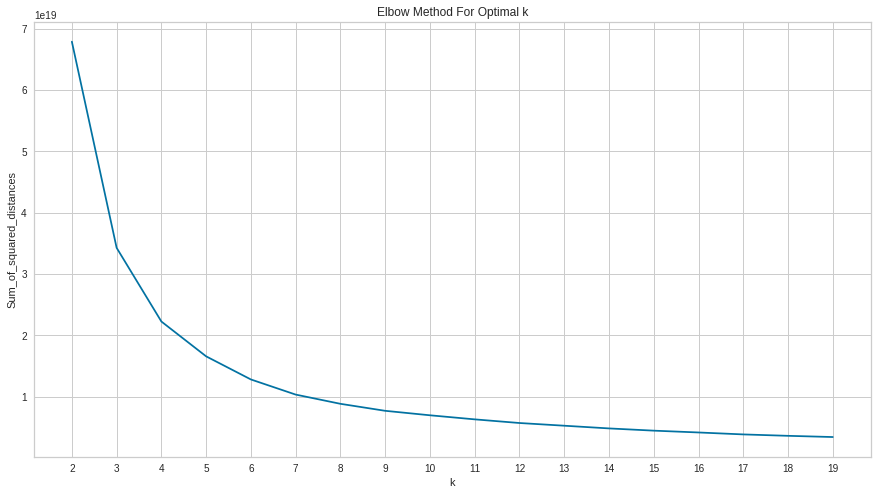

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(2,n), Sum_of_squared_distances, 'bx-')
plt.xticks(range(2,n),range(2,n))
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# yellow brick elbow

In [ ]:
X_full.isnull().sum()

adult                       0
budget                      0
original_language           0
popularity                  0
revenue                     0
vote_average                0
vote_count                  0
original_title              0
overview                    0
tagline                     0
genres_list                 0
genre_hot_encoded           0
genres_list_encoded         0
genres_list_tupled          0
text_concat                 0
vote_average_categorical    0
dtype: int64

In [ ]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39387 entries, 0 to 39386
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   adult                     39387 non-null  int64  
 1   budget                    39387 non-null  int32  
 2   original_language         39387 non-null  int64  
 3   popularity                39387 non-null  float32
 4   revenue                   39387 non-null  int64  
 5   vote_average              39387 non-null  float64
 6   vote_count                39387 non-null  int32  
 7   original_title            39387 non-null  object 
 8   overview                  39387 non-null  object 
 9   tagline                   39387 non-null  object 
 10  genres_list               39387 non-null  object 
 11  genre_hot_encoded         39387 non-null  object 
 12  genres_list_encoded       39387 non-null  int64  
 13  genres_list_tupled        39387 non-null  object 
 14  text_c

In [ ]:
X_full.describe()

adult        budget  ...    vote_count  genres_list_encoded
count  39387.000000  3.938700e+04  ...  39387.000000         39387.000000
mean       0.000229  4.515414e+06  ...    117.841344          2014.106609
std        0.015115  1.794235e+07  ...    509.814671           927.627443
min        0.000000  0.000000e+00  ...      0.000000             0.000000
25%        0.000000  0.000000e+00  ...      4.000000          1507.000000
50%        0.000000  0.000000e+00  ...     11.000000          1952.000000
75%        0.000000  0.000000e+00  ...     38.000000          2383.000000
max        1.000000  3.000000e+08  ...  14075.000000          4063.000000

[8 rows x 8 columns]

In [ ]:
X_full.head()

adult  ...  vote_average_categorical
0      0  ...                       Bad
1      0  ...                       Bad
2      0  ...                       Bad
3      0  ...                       Bad
4      0  ...                       Bad

[5 rows x 16 columns]

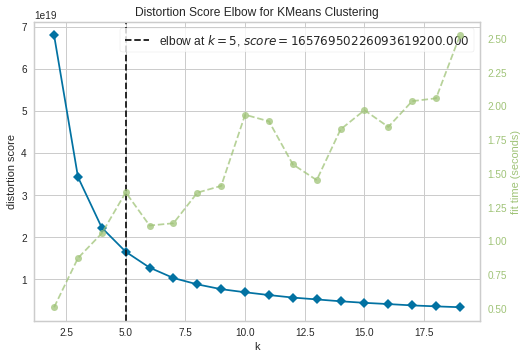

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,20))

visualizer.fit(X_full.loc[:,columns_to_use])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# wordcloud

In [ ]:
#visualizer.elbow_value_
num_clusters=6
kmeans_bow = KMeans(
    n_clusters=num_clusters,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)
kmeans_bow.fit(X_bow_train_full_old)
y_pred_bow = kmeans_bow.fit_predict(X_bow_train_full_old)

centroids_bow = kmeans_bow.cluster_centers_.argsort()[:, ::-1]
terms_bow = count_vectorizer.get_feature_names()

#print(pd.DataFrame(y_pred_bow))
#print(centroids_bow)
#print(terms_bow)

# print('Silhouette Score BoW:', silhouette_score(X_bow[:].todense(), y_pred_bow, metric='euclidean'))
# kmeans_silhouette_scores.append(silhouette_score(X_bow[:].todense(), y_pred_bow, metric='euclidean'))
# print('Kappa Score BoW:', cohen_kappa_score(y_pred_bow, y_encoded))
# kmeans_kappa_scores.append(cohen_kappa_score(y_pred_bow, y_encoded))
# kmeans_titles.append('KMeans with BoW')

In [ ]:
centroids_bow = kmeans_bow.cluster_centers_.argsort()[:, ::-1]

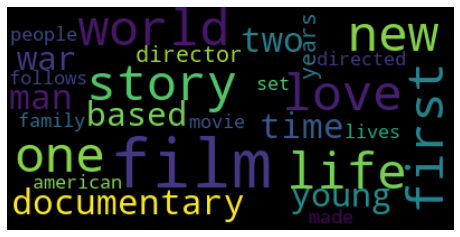

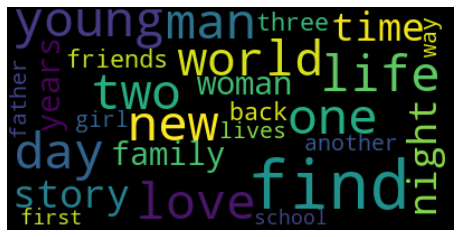

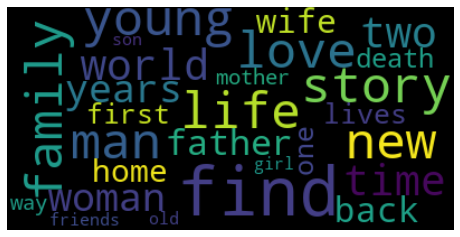

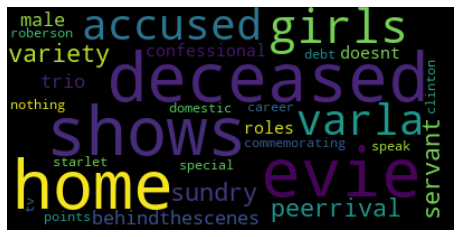

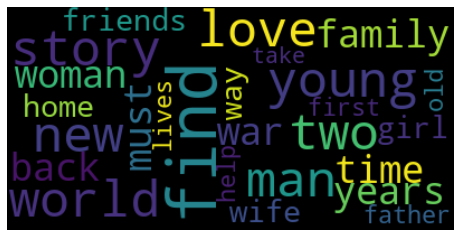

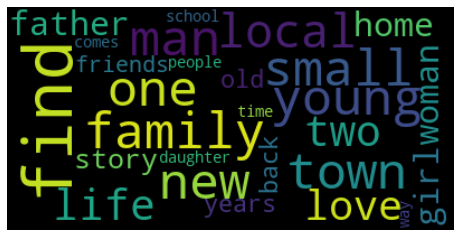

In [ ]:
# WordCloud
clusters = []
for i in range(num_clusters):
    cluster = []
    for ind in centroids_bow[i, :30]:
        cluster.append(terms_bow[ind])
    #print(cluster)
    clusters.append(' '.join(str(''.join(str(x) for x in v)) for v in cluster))


for i in range(len(clusters)):
    cluster_words = "".join(str(x) for x in clusters[i])
    wordcloud = WordCloud(max_font_size = 60).generate(cluster_words)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

# SVM

In [ ]:
class_mapping=['Comedy', 'Documentary', 'Drama', 'Romance']

In [ ]:
def stretch_dataset(x,y, train=True):

  X_stretch=[]
  y_stretch=[]
  for i,j in zip(x,y):
      for z in j:
          X_stretch.append(i)
          y_stretch.append(z)

  if train:
    new_data = X_stretch
    new_classes = y_stretch

    for i in range(len(unique_genres)-2):
      new_data, new_classes = ADASYN(sampling_strategy='minority', random_state=RANDOM_STATE).fit_resample(new_data, new_classes)

    X_stretch, y_stretch = new_data, new_classes
  return X_stretch,y_stretch

In [ ]:
# train svm model with svm_concat_numpy
from sklearn.svm import SVC
model = SVC(gamma='auto',probability=True)

X_train_stretch, y_train_stretch = stretch_dataset(X_bow_train, X_train.loc[:,column_target[0]],train=True)
X_test_stretch, y_test_stretch = stretch_dataset(X_bow_test, X_test.loc[:,column_target[0]],train=False)

model.fit(X_train_stretch, y_train_stretch)

SVC(gamma='auto', probability=True)

In [ ]:
print("SVM accuracy on train data :", model.score(X_train_stretch,y_train_stretch))

SVM accuracy on train data : 0.4993479256987769


In [ ]:
print("SVM accuracy on test data :", model.score(X_test_stretch,y_test_stretch))

SVM accuracy on test data : 0.39209189308592884


In [ ]:
n=19
print("predicted genres:")
for index,i in enumerate(model.predict_proba(pd.DataFrame(X_test_stretch[n]).T)[0]):
  if i>0.3:
    print(model.classes_[index],end=" ")
#print("argmax prediction:",model.classes_[np.argmax(model.predict_proba(pd.DataFrame(X_test_stretch[n]).T)[0])])
#print("True label:",y_test_stretch[n])

predicted genres:
Documentary 

In [ ]:
model.classes_

array(['Comedy', 'Documentary', 'Drama', 'Romance'], dtype='<U11')

In [ ]:
X_train.columns

Index(['adult', 'budget', 'original_language', 'popularity', 'revenue',
       'vote_average', 'vote_count', 'original_title', 'overview', 'tagline',
       'genres_list', 'genre_hot_encoded', 'genres_list_encoded',
       'genres_list_tupled', 'text_concat', 'vote_average_categorical'],
      dtype='object')

In [ ]:
for i in model.classes_:
  print(i,len(X_train[X_train["genres_list"].map(set([i]).issubset)]))

Comedy 5680
Documentary 2160
Drama 7362
Romance 3057


In [ ]:
i,j=np.unique(X_train[X_train["genres_list"].map(set(["Comedy"]).issubset)]["genres_list_tupled"],return_counts=True)
pd.DataFrame(j.reshape(1,-1),columns=list(map(str,list(i))))

('Comedy',)  ...  ('Comedy', 'Romance')
0         2669  ...                    898

[1 rows x 4 columns]

In [ ]:
i,j=np.unique(X_train[X_train["genres_list"].map(set(["Drama"]).issubset)]["genres_list_tupled"],return_counts=True)
pd.DataFrame(j.reshape(1,-1),columns=list(map(str,list(i))))

('Comedy', 'Drama')  ...  ('Drama', 'Romance')
0                 1277  ...                  1323

[1 rows x 4 columns]

In [ ]:
i,j=np.unique(X_train[X_train["genres_list"].map(set(["Documentary"]).issubset)]["genres_list_tupled"],return_counts=True)
pd.DataFrame(j.reshape(1,-1),columns=list(map(str,list(i))))

('Documentary',)
0              2160

In [ ]:
i,j=np.unique(X_train[X_train["genres_list"].map(set(["Romance"]).issubset)]["genres_list_tupled"],return_counts=True)
pd.DataFrame(j.reshape(1,-1),columns=list(map(str,list(i))))

('Comedy', 'Drama', 'Romance')  ('Comedy', 'Romance')  ('Drama', 'Romance')
0                             836                    898                  1323

In [ ]:
for i in model.classes_:
  print(i,len(X_test[X_test["genres_list"].map(set([i]).issubset)]))

Comedy 1463
Documentary 522
Drama 1819
Romance 723


In [ ]:
np.unique(X_test[X_test["genres_list"].map(set(["Drama"]).issubset)]["genres_list_tupled"],return_counts=True)

(array([('Comedy', 'Drama'), ('Comedy', 'Drama', 'Romance'), ('Drama',),
        ('Drama', 'Romance')], dtype=object), array([342, 189, 984, 304]))

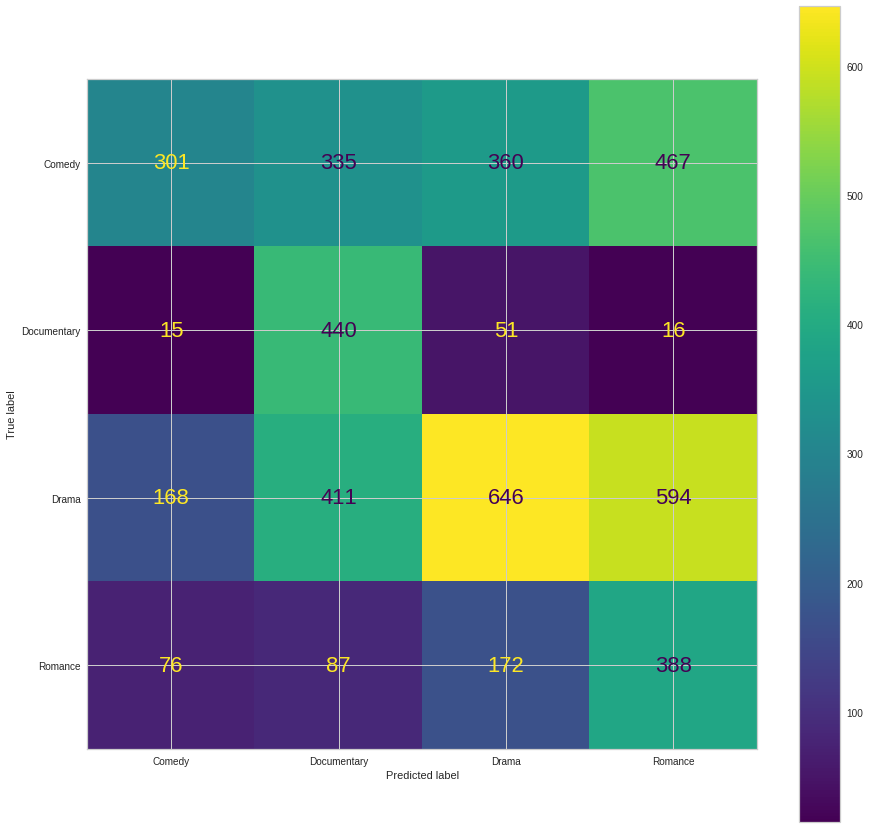

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(15, 15))

plot_confusion_matrix(model,X_test_stretch,y_test_stretch, ax=ax)


In [ ]:
print(classification_report(y_test_stretch,model.predict(X_test_stretch)))

              precision    recall  f1-score   support

      Comedy       0.54      0.21      0.30      1463
 Documentary       0.35      0.84      0.49       522
       Drama       0.53      0.36      0.42      1819
     Romance       0.26      0.54      0.35       723

    accuracy                           0.39      4527
   macro avg       0.42      0.49      0.39      4527
weighted avg       0.47      0.39      0.38      4527



In [ ]:
confusion_matrix(y_test_stretch,model.predict(X_test_stretch))

array([[301, 335, 360, 467],
       [ 15, 440,  51,  16],
       [168, 411, 646, 594],
       [ 76,  87, 172, 388]])

# SVM using multiOutputClassifier

In [ ]:
multioutput_model = SVC(gamma="auto",kernel="rbf",C=0.1,probability=True)
multioutput_model = MultiOutputClassifier(multioutput_model, n_jobs=-1)

# edit to make it with the other features as well not the text data only
multioutput_model.fit(X_bow_train,np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))

MultiOutputClassifier(estimator=SVC(C=0.1, gamma='auto', probability=True),
                      n_jobs=-1)

In [ ]:
multioutput_model.predict_proba(pd.DataFrame(X_bow_train[0]).T)

[array([[0.62581133, 0.37418867]]),
 array([[0.4911042, 0.5088958]]),
 array([[0.7604203, 0.2395797]]),
 array([[0.83383302, 0.16616698]])]

In [ ]:
print("SVM multiOutputClassifier on train data score :",multioutput_model.score(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8")))

SVM multiOutputClassifier on train data score : 0.25341890136756057


In [ ]:
print("SVM multiOutputClassifier on test data score :",multioutput_model.score(X_bow_test, np.array(X_test.loc[:,column_target[1]].to_list(),dtype="uint8")))

SVM multiOutputClassifier on test data score : 0.2655056523067522


In [ ]:
cm_svm_moc=multilabel_confusion_matrix(np.array(X_test.loc[:,column_target[1]].to_list()),multioutput_model.predict(pd.DataFrame(X_bow_test)))

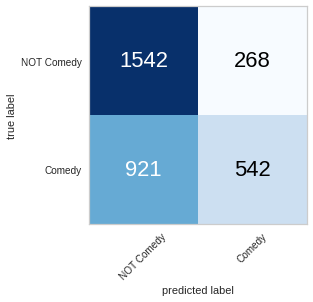

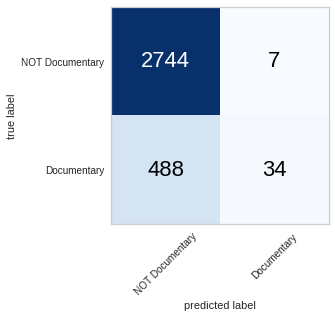

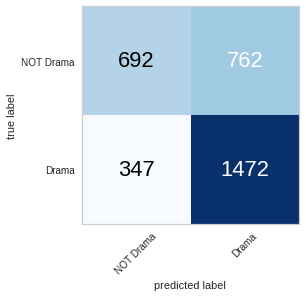

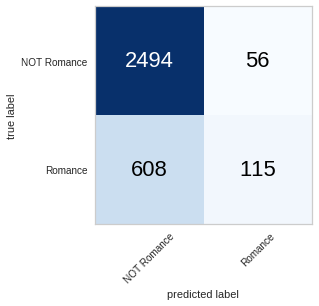

In [ ]:
for i in range(cm_svm_moc.shape[0]):
  fig, ax = mlxcf(conf_mat=cm_svm_moc[i],class_names=["NOT "+class_mapping[i],class_mapping[i]])
  plt.show()

# OVR SVM


In [ ]:
# using strectch varibale for one verses rest classifer
clf = OneVsRestClassifier(SVC(probability=True)).fit(X_train_stretch,y_train_stretch)


In [ ]:
print("OVR SVM on train data score :",clf.score(X_train_stretch, y_train_stretch))

OVR SVM on train data score : 0.5373444714673434


In [ ]:
print("OVR SVM on test data score :",clf.score(X_test_stretch, y_test_stretch))

OVR SVM on test data score : 0.3381930638391871


In [ ]:
clf.predict_proba(pd.DataFrame(X_test_stretch[0]).T)

array([[0.2667184 , 0.07974489, 0.33721599, 0.31632072]])

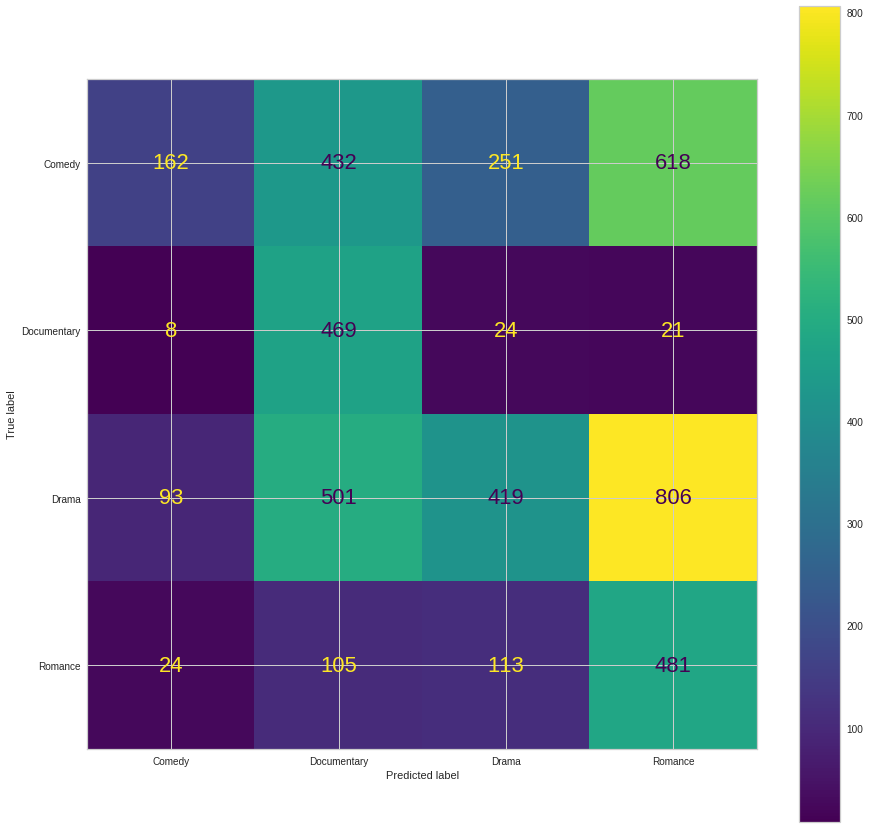

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(15, 15))

plot_confusion_matrix(clf,X_test_stretch,y_test_stretch, ax=ax)

# Gaussain NB

In [ ]:
# class_mapping=['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
#        'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
#        'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
#        'TV Movie', 'Thriller', 'War', 'Western']

class_mapping=['Comedy', 'Documentary', 'Drama', 'Romance']

In [ ]:
multioutput_model_nb = GaussianNB()
multioutput_model_nb = MultiOutputClassifier(multioutput_model_nb, n_jobs=-1)

multioutput_model_nb.fit(X_bow_train,np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))

MultiOutputClassifier(estimator=GaussianNB(), n_jobs=-1)

In [ ]:
row_num_test=12
print("predicted Genres:")
for index,i in enumerate(multioutput_model_nb.predict_proba(pd.DataFrame(X_bow_train[row_num_test]).T)):
    if np.argmax(i[0])==1:
        print(class_mapping[index])

print("True labels:")
print(X_train.loc[row_num_test,column_target[1]])

print("Predicted probabilities:")
print([i[0][1] for i in multioutput_model_nb.predict_proba(pd.DataFrame(X_bow_train[row_num_test]).T)])


predicted Genres:
Drama
True labels:
[0, 1, 0, 0]
Predicted probabilities:
[0.1634195057708184, 0.36726769984140645, 0.5446736436259753, 0.06016201565981839]


In [ ]:
print("Gaussain MultiOutputClassifier score on train data :",multioutput_model_nb.score(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8")))

Gaussain MultiOutputClassifier score on train data : 0.2475360990144396


In [ ]:
print("Gaussain MultiOutputClassifier score on test data :",multioutput_model_nb.score(X_bow_test, np.array(X_test.loc[:,column_target[1]].to_list(),dtype="uint8")))

Gaussain MultiOutputClassifier score on test data : 0.25236785823403607


In [ ]:
cm_nb=multilabel_confusion_matrix(np.array(X_test.loc[:,column_target[1]].to_list()),multioutput_model_nb.predict(pd.DataFrame(X_bow_test)))

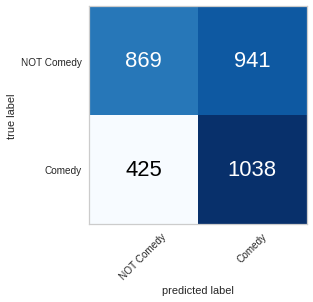

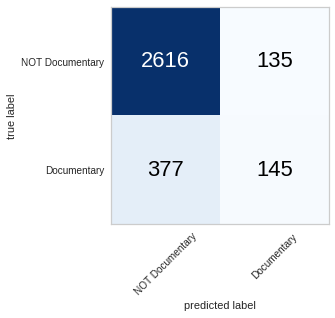

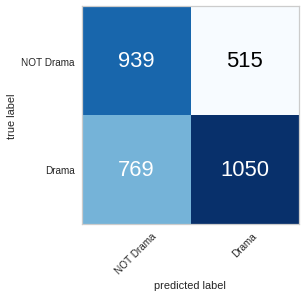

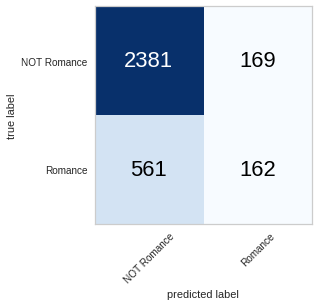

In [ ]:
for i in range(cm_nb.shape[0]):
  fig, ax = mlxcf(conf_mat=cm_nb[i],class_names=["NOT "+class_mapping[i],class_mapping[i]])
  plt.show()

# Random Forest using MultiOutputClassifier

In [ ]:
"""
ValueError: You appear to be using a legacy multi-label data representation. 
Sequence of sequences are no longer supported; use a binary array or sparse matrix instead
the MultiLabelBinarizer transformer can convert to this format.
"""
np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8")

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 1]], dtype=uint8)

In [ ]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

#multi_target_forest.fit(svm_concat_numpy, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))
multi_target_forest.fit(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="uint8"))


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=0),
                      n_jobs=-1)

In [ ]:
multi_target_forest.predict_proba(pd.DataFrame(X_bow_test[9]).T)

[array([[0.37, 0.63]]),
 array([[1., 0.]]),
 array([[0.3, 0.7]]),
 array([[0.81, 0.19]])]

In [ ]:
row_num_test=120
for index,i in enumerate(multi_target_forest.predict_proba(pd.DataFrame(X_bow_test[row_num_test]).T)):
    if np.argmax(i[0])==1:
        print(class_mapping[index],end=" ")
print("")
print("True label:",X_test.loc[row_num_test,column_target[0]])  

Drama 
True label: ['Drama']


In [ ]:
print("Random Forest with multiOutputClassifer score on train data :",multi_target_forest.score(X_bow_train, np.array(X_train.loc[:,column_target[1]].to_list(),dtype="float32")))

Random Forest with multiOutputClassifer score on train data : 0.99946519978608


In [ ]:
print("Random Forest with multiOutputClassifer score on test data :",multi_target_forest.score(X_bow_test, np.array(X_test.loc[:,column_target[1]].to_list(),dtype="float32")))

Random Forest with multiOutputClassifer score on test data : 0.35747021081576535


In [ ]:
cm=multilabel_confusion_matrix(np.array(X_test.loc[:,column_target[1]].to_list()),multi_target_forest.predict(pd.DataFrame(X_bow_test)))

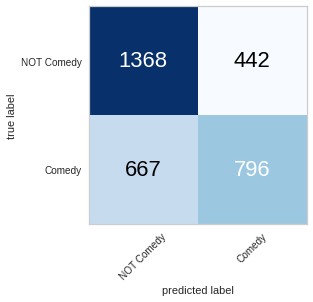

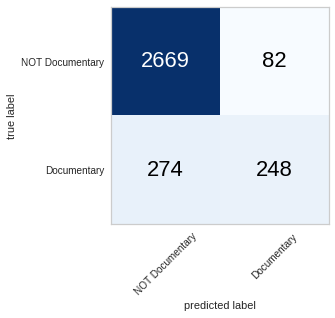

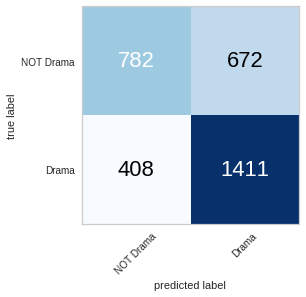

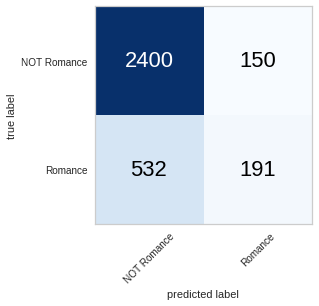

In [ ]:
for i in range(cm.shape[0]):
  fig, ax = mlxcf(conf_mat=cm[i],class_names=["NOT "+class_mapping[i],class_mapping[i]])
  plt.show()

In [ ]:
i,j=np.unique(X_train["genres_list_tupled"],return_counts=True)
pd.DataFrame(j.reshape(1,-1),columns=list(map(str,list(i))))

('Comedy',)  ('Comedy', 'Drama')  ...  ('Drama',)  ('Drama', 'Romance')
0         2669                 1277  ...        3926                  1323

[1 rows x 7 columns]

In [ ]:
i,j=np.unique(X_test["genres_list_tupled"],return_counts=True)
pd.DataFrame(j.reshape(1,-1),columns=list(map(str,list(i))))

('Comedy',)  ('Comedy', 'Drama')  ...  ('Drama',)  ('Drama', 'Romance')
0          702                  342  ...         984                   304

[1 rows x 7 columns]

In [ ]:
for rec_indx in X_test[X_test["genres_list"].map(set(["Comedy"]).issubset)].index[50:80]:
  row_num_test=rec_indx
  print("predicted labels:",end=" ")
  for index,i in enumerate(multi_target_forest.predict_proba(pd.DataFrame(X_bow_test[row_num_test]).T)):
      if np.argmax(i[0])==1:
          print(class_mapping[index],end=" ")
  print("")
  print("True label:",X_test.loc[row_num_test,column_target[0]])
  print(X_test.loc[rec_indx,["text_concat"]].values)
  print("\n")

predicted labels: Drama 
True label: ['Comedy']
['The Young Offenders two teenage boys cycle km stolen bikes pursued police find missing bale cocaine worth million euro set around real event irelands biggest cocaine seizure million euro plans idiot proof']


predicted labels: Comedy 
True label: ['Comedy']
['The Château two brothers go france claim chateau inherited ']


predicted labels: Drama 
True label: ['Comedy', 'Drama', 'Romance']
['Bend It Like Beckham jess bhamra daughter strict indian couple london permitted play organized soccer even though jess playing fun one day impressive skills seen jules paxton convinces jess play semipro team jess uses elaborate excuses hide matches family also dealing romantic feelings coach joe sometimes follow dreams youve got bend rules']


predicted labels: Comedy 
True label: ['Comedy']
['Jim Norton: Contextually Inadequate comedian jim norton tackles twisted state century including modern technology affects everything free speech hooking ']


p

In [ ]:
row_num_test=120
for index,i in enumerate(multi_target_forest.predict_proba(pd.DataFrame(X_bow_test[row_num_test]).T)):
    if np.argmax(i[0])==1:
        print(class_mapping[index],end=" ")
print("")
print("True label:",X_test.loc[row_num_test,column_target[0]])  

# Clustering

## TF-IDF

In [ ]:
tfidf_params = dict(
    sublinear_tf=True,
    min_df=1,
    norm='l2',
    ngram_range=(1,1),
    stop_words='english'
    )

tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

tfidf_vectorizer.fit(X_train_full["text_concat"])
X_tfidf_train_old_full = tfidf_vectorizer.transform(X_train_full["text_concat"])
X_tfidf_test_old_full = tfidf_vectorizer.transform(X_test_full["text_concat"])

#X_tfidf_train_old_full = pd.DataFrame(X_tfidf_train_old_full[:].todense(), columns=tfidf_vectorizer.get_feature_names())
#X_tfidf_test_old_full = pd.DataFrame(X_tfidf_test_old_full[:].todense(), columns=tfidf_vectorizer.get_feature_names())

In [ ]:
# dimensiolity reduction for the data
print(f"previous output of X_bow dimensions is {X_tfidf_train_old_full.shape}")

svd=TruncatedSVD(n_components=10)
svd.fit(X_tfidf_train_old_full)

X_tfidf_full_train = svd.transform(X_tfidf_train_old_full)
# X_tfidf_full_test = svd.transform(X_tfidf_test_old_full)

print(f"New output of X_tfidf dimensions is {X_tfidf_full_train.shape}")

previous output of X_bow dimensions is (33849, 91066)
New output of X_tfidf dimensions is (33849, 10)


## LDA

In [ ]:
docs = X_train_full["text_concat"].map(lambda x: word_tokenize(x)).tolist()
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
print(len(dictionary.items()))

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

7834


In [ ]:
def compute_coherence_values(limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    # Set training parameters.
    chunksize = 2000
    passes = 10
    iterations = 100
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token


    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every,
            random_state=RANDOM_STATE
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')#dictionary=dictionary
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
limit, start, step = len(full_unique_genres)+1, 2, 1
model_list, coherence_values = compute_coherence_values(limit=limit, start=start, step=step)

  0%|          | 0/19 [00:00<?, ?it/s]

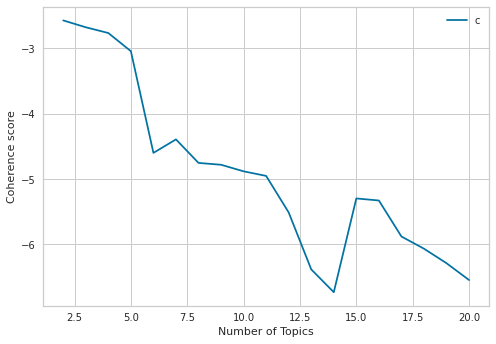

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Number of Topics =", m, "has Coherence Score", round(cv, 4))

Number of Topics = 2 has Coherence Score -2.5717
Number of Topics = 3 has Coherence Score -2.6767
Number of Topics = 4 has Coherence Score -2.7646
Number of Topics = 5 has Coherence Score -3.0428
Number of Topics = 6 has Coherence Score -4.5984
Number of Topics = 7 has Coherence Score -4.3922
Number of Topics = 8 has Coherence Score -4.7521
Number of Topics = 9 has Coherence Score -4.7803
Number of Topics = 10 has Coherence Score -4.8807
Number of Topics = 11 has Coherence Score -4.9509
Number of Topics = 12 has Coherence Score -5.5103
Number of Topics = 13 has Coherence Score -6.3812
Number of Topics = 14 has Coherence Score -6.7302
Number of Topics = 15 has Coherence Score -5.2956
Number of Topics = 16 has Coherence Score -5.3271
Number of Topics = 17 has Coherence Score -5.8778
Number of Topics = 18 has Coherence Score -6.0646
Number of Topics = 19 has Coherence Score -6.2864
Number of Topics = 20 has Coherence Score -6.5441


In [ ]:
# Train LDA model on 7 topics as it's the best number from what we saw above

# Set training parameters.
num_topics = 7
chunksize = 2000
passes = 10
iterations = 100
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

LDA_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_STATE
)

top_topics = LDA_model.top_topics(corpus)


In [ ]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -4.3922.


In [ ]:
# Family, Drama/school, Crime, Documentary, Romance, Action/Thriller, Comedy 

In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(LDA_model, corpus, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.156238 -0.024611       1        1  34.924497
0      0.192519  0.095587       2        1  16.919168
3      0.107980 -0.098204       3        1  15.514748
5     -0.011239 -0.130967       4        1  14.721693
6      0.091558  0.245268       5        1   7.939834
4     -0.166141 -0.293872       6        1   7.875049
2     -0.370915  0.206800       7        1   2.105012, topic_info=          Term         Freq        Total Category  logprob  loglift
128       film  4152.000000  4152.000000  Default  30.0000  30.0000
427      young  4932.000000  4932.000000  Default  29.0000  29.0000
570        the  2292.000000  2292.000000  Default  28.0000  28.0000
236      story  3955.000000  3955.000000  Default  27.0000  27.0000
16         new  4548.000000  4548.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
5827      jeff   153.696399   157.091400   Topic7  -4.8875   3.8390
721        joe   314.703316   347.364460   Topic7  -4.1709   3.7621
5760  magazine   105.379065   113.188479   Topic7  -5.2650   3.7894
3926     kevin   107.622905   123.987563   Topic7  -5.2439   3.7193
3193   william   107.407051   210.166364   Topic7  -5.2459   3.1896

[419 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
123       2  0.008007        !
123       4  0.076065        !
123       5  0.908775        !
123       6  0.008007        !
846       1  0.273056       's
...     ...       ...      ...
122       5  0.998163     york
427       1  0.997175    young
427       2  0.000203    young
427       3  0.002433    young
1434      1  0.995600  younger

[762 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 6, 7, 5, 3])

In [ ]:
# Final model with 8 topics coherence score
coherence_model = CoherenceModel(model=LDA_model, corpus=corpus, coherence='u_mass')
print(f"LDA with {num_topics} topics coherence score:", coherence_model.get_coherence())

LDA with 7 topics coherence score: -4.392171559012273


In [ ]:
topics = ["Family", "Drama/school", "Crime", "Documentary", "Romance", "Action/Thriller", "Comedy"]

sunburst_df = pd.DataFrame()
for i in range(num_topics):
    tmp_df = pd.DataFrame(LDA_model.show_topic(topicid=i, topn=10))
    tmp_df[1] = topics[i]
    sunburst_df = pd.concat([sunburst_df, tmp_df])
sunburst_df.head(20)

0             1
0      get        Family
1   school        Family
2       go        Family
3  friends        Family
4     make        Family
5      new        Family
6     gets        Family
7      hes        Family
8   friend        Family
9    night        Family
0     life  Drama/school
1    young  Drama/school
2     love  Drama/school
3      one  Drama/school
4      two  Drama/school
5   family  Drama/school
6      man  Drama/school
7    woman  Drama/school
8    years  Drama/school
9      The  Drama/school

In [ ]:
fig = px.sunburst(sunburst_df, path=[1, 0])
fig.show()

In [ ]:
# pickle.dump(LDA_model, open("LDA_model.pkl", "wb"))

## LDA hyperparamter tuning  

In [ ]:
dictionary_param_tuning = Dictionary(docs)

# Filter out words that occur less than 0 documents, or more than 20% of the documents.
dictionary_param_tuning.filter_extremes(no_below=0, no_above=0.2)
print(len(dictionary_param_tuning.items()))

# Bag-of-words representation of the documents.
corpus_param_tuning = [dictionary_param_tuning.doc2bow(doc) for doc in docs]

100000


In [ ]:
def compute_coherence_param_tuning(limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    # Set training parameters.
    chunksize_param_tuning = 2000
    passes_param_tuning = 10
    iterations_param_tuning = 100
    eval_every_param_tuning = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary_param_tuning[0]  # This is only to "load" the dictionary.
    id2word_param_tuning = dictionary_param_tuning.id2token


    coherence_values_param_tuning = []
    model_list_param_tuning = []
    for num_topics_param_tuning in tqdm(range(start, limit, step)):
        model_param_tuning = LdaModel(
            corpus=corpus_param_tuning,
            id2word=id2word_param_tuning,
            chunksize=chunksize_param_tuning,
            alpha='auto',
            eta='auto',
            iterations=iterations_param_tuning,
            num_topics=num_topics_param_tuning,
            passes=passes_param_tuning,
            eval_every=eval_every_param_tuning,
            random_state=RANDOM_STATE
        )
        model_list_param_tuning.append(model_param_tuning)
        coherencemodel_param_tuning = CoherenceModel(model=model_param_tuning, corpus=corpus_param_tuning, coherence='u_mass')#dictionary=dictionary
        coherence_values_param_tuning.append(coherencemodel_param_tuning.get_coherence())

    return model_list_param_tuning, coherence_values_param_tuning

In [ ]:
# Can take a long time to run.
limit_param_tuning, start_param_tuning, step_param_tuning = len(full_unique_genres) + 1, 2, 1
model_list_param_tuning, coherence_values_param_tuning = compute_coherence_param_tuning(limit=limit_param_tuning, start=start_param_tuning, step=step_param_tuning)

  0%|          | 0/19 [00:00<?, ?it/s]

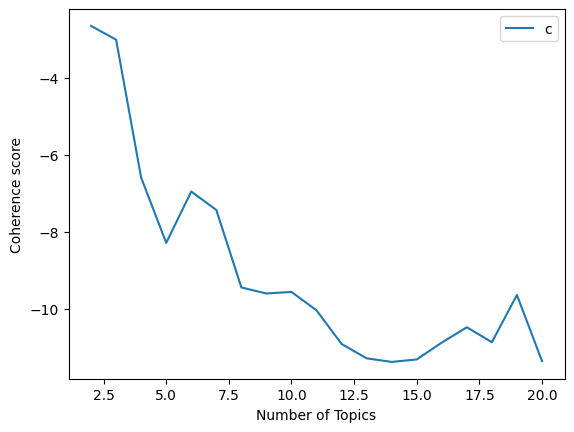

In [ ]:
# Show graph
x = range(start_param_tuning, limit_param_tuning, step_param_tuning)
plt.plot(x, coherence_values_param_tuning)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values_param_tuning):
    print("Number of Topics =", m, "has Coherence Score", round(cv, 4))

Number of Topics = 2 has Coherence Score -2.6482
Number of Topics = 3 has Coherence Score -3.0063
Number of Topics = 4 has Coherence Score -6.5898
Number of Topics = 5 has Coherence Score -8.2804
Number of Topics = 6 has Coherence Score -6.9473
Number of Topics = 7 has Coherence Score -7.4277
Number of Topics = 8 has Coherence Score -9.4392
Number of Topics = 9 has Coherence Score -9.5959
Number of Topics = 10 has Coherence Score -9.5548
Number of Topics = 11 has Coherence Score -10.0334
Number of Topics = 12 has Coherence Score -10.9057
Number of Topics = 13 has Coherence Score -11.2792
Number of Topics = 14 has Coherence Score -11.3724
Number of Topics = 15 has Coherence Score -11.3079
Number of Topics = 16 has Coherence Score -10.8702
Number of Topics = 17 has Coherence Score -10.4725
Number of Topics = 18 has Coherence Score -10.8609
Number of Topics = 19 has Coherence Score -9.6332
Number of Topics = 20 has Coherence Score -11.3502


In [ ]:
# Train LDA model on 6 topics as it's the best number from what we saw above

# Set training parameters.
num_topics_param_tuning = 6
chunksize_param_tuning = 2000
passes_param_tuning = 10
iterations_param_tuning = 100
eval_every_param_tuning = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp_param_tuning = dictionary_param_tuning[0]  # This is only to "load" the dictionary.
id2word_param_tuning = dictionary_param_tuning.id2token

LDA_model_param_tuning = LdaModel(
    corpus=corpus_param_tuning,
    id2word=id2word_param_tuning,
    chunksize=chunksize_param_tuning,
    alpha='auto',
    eta='auto',
    iterations=iterations_param_tuning,
    num_topics=num_topics_param_tuning,
    passes=passes_param_tuning,
    eval_every=eval_every_param_tuning,
    random_state=RANDOM_STATE
)

top_topics_param_tuning = LDA_model_param_tuning.top_topics(corpus_param_tuning)


In [ ]:
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics. (param tuned)
avg_topic_coherence_param_tuning = sum([t[1] for t in top_topics_param_tuning]) / num_topics_param_tuning
print('Average topic coherence: %.4f.' % avg_topic_coherence_param_tuning)

Average topic coherence: -6.9473.


In [ ]:
pyLDAvis.enable_notebook()
vis_param_tuning = gensimvis.prepare(LDA_model_param_tuning, corpus_param_tuning, dictionary=dictionary_param_tuning)
vis_param_tuning

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.328386  0.036157       1        1  54.498807
0     -0.058697 -0.307620       2        1  15.112458
5     -0.034989  0.053617       3        1  12.409230
1     -0.010846  0.226501       4        1  12.397328
3      0.228233 -0.003350       5        1   3.371929
2      0.204685 -0.005305       6        1   2.210248, topic_info=              Term         Freq        Total Category  logprob  loglift
157           film  4150.000000  4150.000000  Default  30.0000  30.0000
130          world  3581.000000  3581.000000  Default  29.0000  29.0000
702            war  2177.000000  2177.000000  Default  28.0000  28.0000
66             The  5572.000000  5572.000000  Default  27.0000  27.0000
765             of  2461.000000  2461.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
14412       pushes    37.009209    37.808570   Topic6  -6.5995   3.7907
8466   appearances    37.143095    37.945834   Topic6  -6.5959   3.7907
8381       martial    65.257391   197.392282   Topic6  -6.0323   2.7052
6525          arts    51.014352   197.528540   Topic6  -6.2786   2.4583
2777         china    39.562524   181.926336   Topic6  -6.5328   2.2863

[323 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
557        1  0.005823       :
557        2  0.267437       :
557        3  0.267853       :
557        4  0.458344       :
13797      4  0.996829      In
...      ...       ...     ...
265        4  0.000695   years
555        1  0.999493   young
555        2  0.000390   young
3841       5  0.982711  zombie
720        5  0.991700       à

[473 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 2, 4, 3])

# K-Means - Ansary's edits


In [ ]:
# Init metrics
kmeans_silhouette_scores = []
kmeans_kappa_scores = []
kmeans_titles = []

# Encoding categorical data
y_encoded = X_train_full["genres_list_encoded"]

def kmeans_pca(n_clusters, features, title):
    pca = PCA(n_components=2, random_state=0)
    pca_features = pca.fit_transform(features)

    kmeans_model = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300, 
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    kmeans_model.fit(pca_features)
    y_pred = kmeans_model.predict(pca_features)
    
    print('Silhouette Score PCA:', silhouette_score(pca_features, y_pred, metric='euclidean'))
    kmeans_silhouette_scores.append(silhouette_score(pca_features, y_pred, metric='euclidean'))
    print('Kappa Score PCA:', cohen_kappa_score(y_pred, y_encoded))
    kmeans_kappa_scores.append(cohen_kappa_score(y_pred, y_encoded))
    kmeans_titles.append(title+' PCA')

    return kmeans_model, pca_features, y_pred

def kmeans_tsne(n_clusters, features, title):
    tsne = TSNE(n_components=2, random_state=0)
    tsne_features = tsne.fit_transform(features)

    kmeans_model = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300, 
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    kmeans_model.fit(tsne_features)
    y_pred = kmeans_model.predict(tsne_features)

    print('Silhouette Score T-SNE:', silhouette_score(tsne_features, y_pred, metric='euclidean'))
    kmeans_silhouette_scores.append(silhouette_score(tsne_features, y_pred, metric='euclidean'))
    print('Kappa Score T-SNE:', cohen_kappa_score(y_pred, y_encoded))
    kmeans_kappa_scores.append(cohen_kappa_score(y_pred, y_encoded))
    kmeans_titles.append(title+' T-SNE')

    return kmeans_model, tsne_features, y_pred

def kmeans_svd(n_clusters, features, title="", verbose=True):
    svd = TruncatedSVD(n_components=2, random_state=0)
    svd_features = svd.fit_transform(features)

    kmeans_model = KMeans(
        n_clusters=n_clusters,
        init='k-means++',
        n_init=10,
        max_iter=300, 
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    kmeans_model.fit(svd_features)
    y_pred = kmeans_model.predict(svd_features)
    
    print('Silhouette Score SVD:', silhouette_score(svd_features, y_pred, metric='euclidean'))
    print('Kappa Score SVD:', cohen_kappa_score(y_pred, y_encoded))
    if verbose:
        kmeans_silhouette_scores.append(silhouette_score(svd_features, y_pred, metric='euclidean'))
        kmeans_kappa_scores.append(cohen_kappa_score(y_pred, y_encoded))
        kmeans_titles.append(title+' SVD')

    return kmeans_model, svd_features, y_pred

def kmeans_dimensionality_reduction(n_clusters, features, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 4.8))
    fig.suptitle(title)

    tsne_kmeans_model, tsne_features , tsne_y_pred = kmeans_tsne(n_clusters, features, title)
    svd_kmeans_model, svd_features , svd_y_pred = kmeans_svd(n_clusters, features, title)
    
    axs[0].scatter(tsne_features[:,0], tsne_features[:, 1], s = 20, c = tsne_y_pred)
    axs[0].set_title('T-SNE')
    axs[1].scatter(svd_features[:,0], svd_features[:, 1], s = 20, c = svd_y_pred)
    axs[1].set_title('SVD')

## Elbow Method with BoW

The Elbow Method


  0%|          | 0/20 [00:00<?, ?it/s]

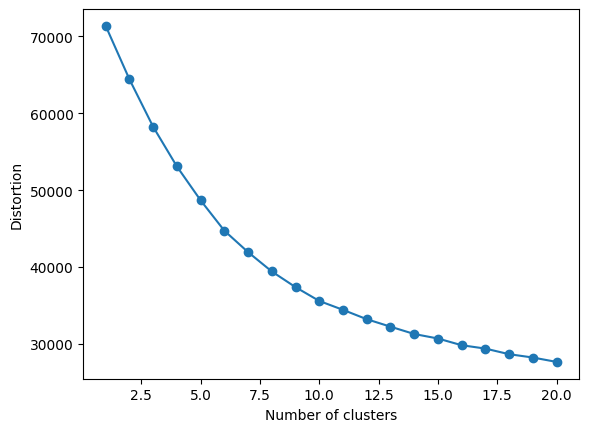

In [ ]:
# The Elbow Method
print("The Elbow Method")
# calculate distortion for a range of number of cluster
distortions_bow = []
for i in tqdm(range(1, len(full_unique_genres) + 1)):
    km_bow = KMeans(
        n_clusters=i,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=RANDOM_STATE
    )
    km_bow.fit(X_bow_full_train)
    distortions_bow.append(km_bow.inertia_)

# plot
plt.plot(range(1, len(full_unique_genres) + 1), distortions_bow, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

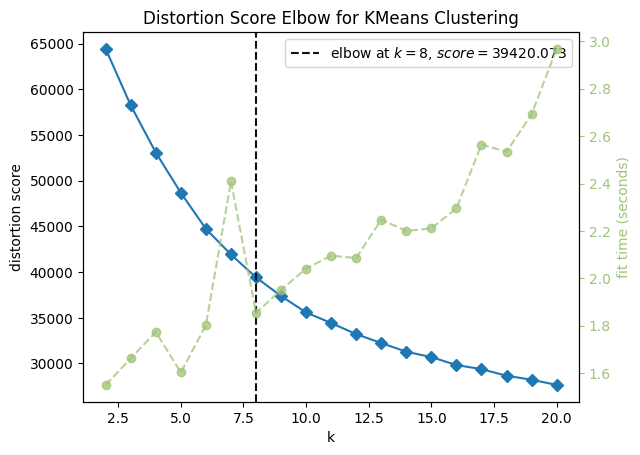

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2, len(full_unique_genres) + 1))

visualizer.fit(X_bow_full_train)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
plt.style.use('default')

In [ ]:
visualizer.elbow_value_

8

Silhouette Score T-SNE: 0.36160064
Kappa Score T-SNE: -2.6502009575324337e-05
Silhouette Score SVD: 0.3912244446290448
Kappa Score SVD: 5.5248749851743995e-06


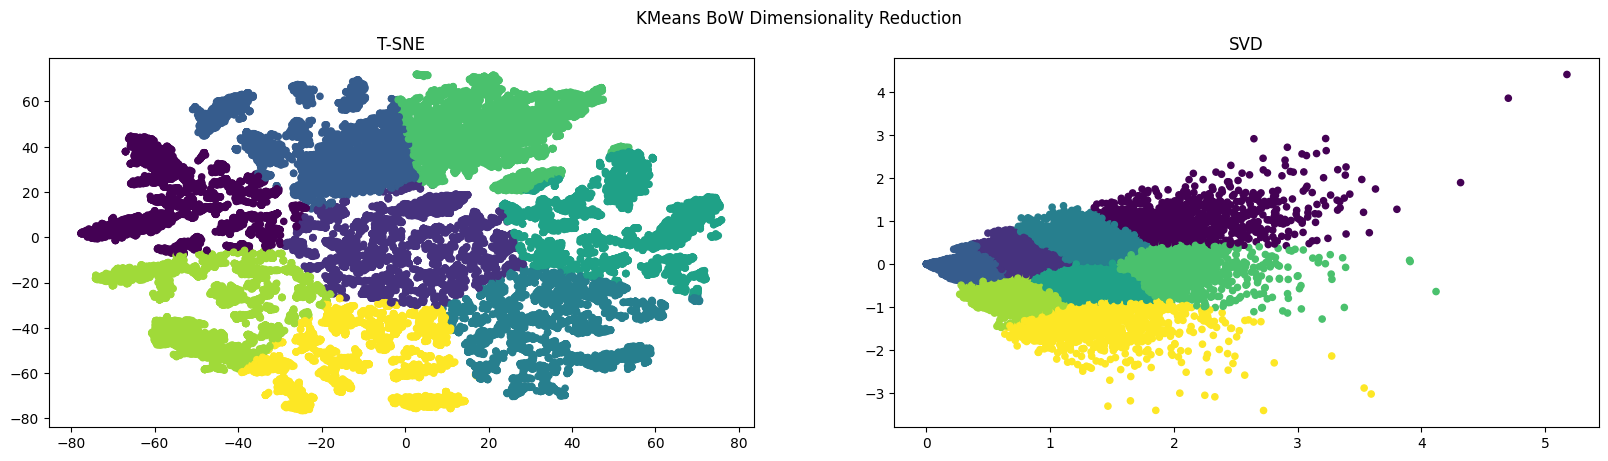

In [ ]:
kmeans_dimensionality_reduction(visualizer.elbow_value_, X_bow_full_train, "KMeans BoW Dimensionality Reduction")

## K-Means with BoW

In [ ]:
kmeans_bow = KMeans(
    n_clusters=visualizer.elbow_value_,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)
kmeans_bow.fit(X_bow_full_train)
y_pred_bow = kmeans_bow.fit_predict(X_bow_full_train)

centroids_bow = kmeans_bow.cluster_centers_.argsort()[:, ::-1]
terms_bow = count_vectorizer.get_feature_names()

# print(pd.DataFrame(y_pred_bow))
# print(centroids_bow)
# print(terms_bow)

# print('Silhouette Score BoW:', silhouette_score(X_bow[:].todense(), y_pred_bow, metric='euclidean'))
kmeans_silhouette_scores.append(silhouette_score(X_bow_full_train[:], y_pred_bow, metric='euclidean'))
# print('Kappa Score BoW:', cohen_kappa_score(y_pred_bow, y_encoded))
kmeans_kappa_scores.append(cohen_kappa_score(y_pred_bow, y_encoded))
kmeans_titles.append('KMeans with BoW')

In [ ]:
# WordCloud
clusters = []
for i in range(visualizer.elbow_value_):
    cluster = []
    for ind in centroids_bow[i, :30]:
        print()
        cluster.append(terms_bow[ind])
    clusters.append(' '.join(str(''.join(str(x) for x in v)) for v in cluster))

for i in range(len(clusters)):
    cluster_words = "".join(str(x) for x in clusters[i])
    
    wordcloud = WordCloud(max_font_size = 60).generate(cluster_words)
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

## K-Means with TF-IDF

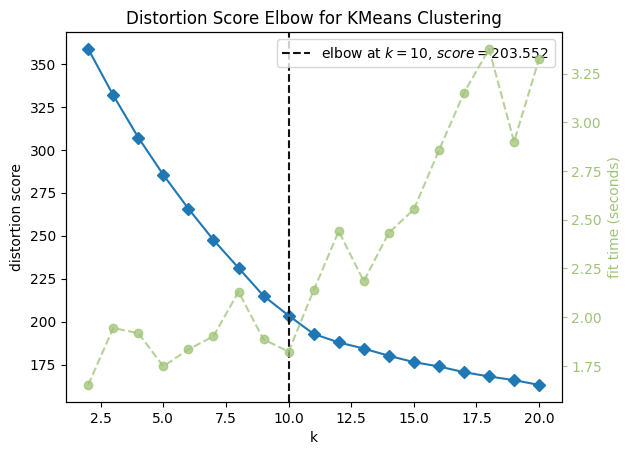

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model_tfidf = KMeans(random_state=0)
visualizer_tdidf = KElbowVisualizer(model_tfidf, k=(2, len(full_unique_genres) + 1))

visualizer_tdidf.fit(X_tfidf_full_train)        # Fit the data to the visualizer
visualizer_tdidf.show()        # Finalize and render the figure

In [ ]:
if visualizer_tdidf.elbow_value_ != None:
  kmeans_tfidf = KMeans(
      n_clusters=visualizer_tdidf.elbow_value_,
      init='k-means++',
      n_init=10,
      max_iter=300, 
      tol=1e-04,
      random_state=RANDOM_STATE
  )
  kmeans_tfidf.fit(X_tfidf_full_train)
  y_pred_tfidf = kmeans_tfidf.fit_predict(X_tfidf_full_train)

  centroids_tfidf = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]
  terms_tfidf = tfidf_vectorizer.get_feature_names()

  # print(pd.DataFrame(y_pred_tfidf))
  # print(centroids_tfidf)
  # print(terms_tfidf)

  # print('Silhouette Score TF-IDF:', silhouette_score(X_tfidf[:].todense(), y_pred_tfidf, metric='euclidean'))
  kmeans_silhouette_scores.append(silhouette_score(X_tfidf_full_train[:], y_pred_tfidf, metric='euclidean'))
  # print('Kappa Score TF-IDF:', cohen_kappa_score(y_pred_tfidf, y_encoded))
  kmeans_kappa_scores.append(cohen_kappa_score(y_pred_tfidf, y_encoded))
  kmeans_titles.append('KMeans with TF-IDF')


  print(kmeans_silhouette_scores)
  print(kmeans_kappa_scores)

[0.36160064, 0.3912244446290448, 0.2311088645667413, 0.1708210538934005, 0.1708210538934005]
[-2.6502009575324337e-05, 5.5248749851743995e-06, 7.759300452159223e-07, -2.3692366905692097e-05, -2.3692366905692097e-05]


In [ ]:
print(kmeans_kappa_scores,kmeans_silhouette_scores,kmeans_titles)

[-2.6502009575324337e-05, 5.5248749851743995e-06, 7.759300452159223e-07, -2.3692366905692097e-05] [0.36160064, 0.3912244446290448, 0.2311088645667413, 0.1708210538934005] ['KMeans BoW Dimensionality Reduction T-SNE', 'KMeans BoW Dimensionality Reduction SVD', 'KMeans with BoW', 'KMeans with TF-IDF']


In [ ]:
if visualizer_tdidf.elbow_value_ != None:
  # WordCloud
  clusters = []
  for i in range(visualizer_tdidf.elbow_value_):
      cluster = []
      for ind in centroids_tfidf[i, :30]:
          cluster.append(terms_tfidf[ind])
      clusters.append(' '.join(str(''.join(str(x) for x in v)) for v in cluster))

  for i in range(len(clusters)):
      cluster_words = "".join(str(x) for x in clusters[i])
      wordcloud = WordCloud(max_font_size = 60).generate(cluster_words)
      plt.figure(figsize=(8,6))
      plt.imshow(wordcloud, interpolation = "bilinear")
      plt.axis("off")
      plt.show()

## K-Means with LDA

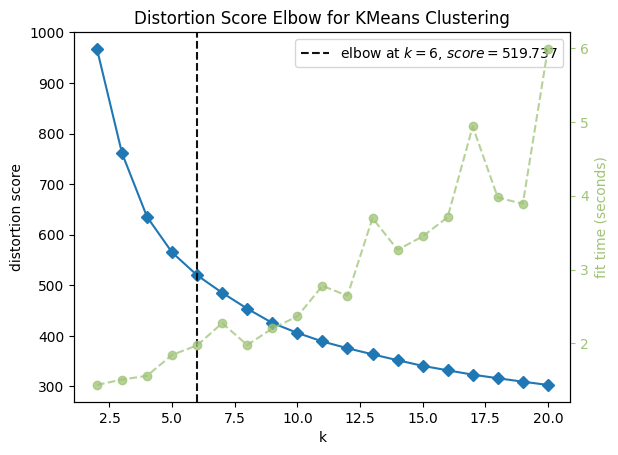

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# transforming LDA model output to numpy array so we can use it in our model
topics_sparse_matrix = gensim.matutils.corpus2csc(LDA_model[corpus])
topics_numpy_array = topics_sparse_matrix.T.toarray()

# Instantiate the clustering model and visualizer
model_lda = KMeans(random_state=0)
visualizer_lda = KElbowVisualizer(model_lda, k=(2, len(full_unique_genres) + 1))

visualizer_lda.fit(topics_numpy_array)        # Fit the data to the visualizer
visualizer_lda.show()        # Finalize and render the figure

In [ ]:
# transforming LDA model output to numpy array so we can use it in our model
topics_sparse_matrix = gensim.matutils.corpus2csc(LDA_model[corpus])
topics_numpy_array = topics_sparse_matrix.T.toarray()

# start modeling and training
kmeans_lda = KMeans(
    n_clusters=6,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)

y_pred_lda = kmeans_lda.fit_predict(topics_numpy_array)

centroids_lda = kmeans_lda.cluster_centers_.argsort()[:, ::-1]
terms_lda = count_vectorizer.get_feature_names()
    
# print(pd.DataFrame(y_pred_lda))
# print(centroids_lda)
# print(terms_lda)

# print('Silhouette Score LDA:', silhouette_score(topics_numpy_array, y_pred_lda, metric='euclidean'))
kmeans_silhouette_scores.append(silhouette_score(topics_numpy_array, y_pred_lda, metric='euclidean'))
# print('Kappa Score LDA:', cohen_kappa_score(y_pred_lda, y_encoded))
kmeans_kappa_scores.append(cohen_kappa_score(y_pred_lda, y_encoded))
kmeans_titles.append('KMeans with LDA')

## K-Means with LDA

In [ ]:
# start modeling and training
kmeans_lda_param_tuning = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=10,
    max_iter=300, 
    tol=1e-04,
    random_state=RANDOM_STATE
)

y_pred_lda_param_tuning = kmeans_lda_param_tuning.fit_predict(topics_numpy_array)

centroids_lda_param_tuning = kmeans_lda_param_tuning.cluster_centers_.argsort()[:, ::-1]
terms_lda_param_tuning = count_vectorizer.get_feature_names()
    
# print(pd.DataFrame(y_pred_lda_param_tuning))
# print(centroids_lda_param_tuning)
# print(terms_lda_param_tuning)

# print('Silhouette Score LDA 5 Clusters:', silhouette_score(topics_numpy_array, y_pred_lda_param_tuning, metric='euclidean'))
kmeans_silhouette_scores.append(silhouette_score(topics_numpy_array, y_pred_lda, metric='euclidean'))
# print('Kappa Score LDA 5 Clusters:', cohen_kappa_score(y_pred_lda_param_tuning, y_encoded))
kmeans_kappa_scores.append(cohen_kappa_score(y_pred_lda, y_encoded))
kmeans_titles.append('KMeans with LDA 5 Clusters')

## K-Means Evaluation

In [ ]:
kmeans_silhouette_scores

[0.36160064,
 0.3912244446290448,
 0.2311088645667413,
 0.1708210538934005,
 0.2209021449569596,
 0.2209021449569596]

In [ ]:
kmeans_kappa_scores

[-2.6502009575324337e-05,
 5.5248749851743995e-06,
 7.759300452159223e-07,
 -2.3692366905692097e-05,
 -2.3800597644951793e-05,
 -2.3800597644951793e-05]

In [ ]:
kmeans_kappa_scores[0]*100

-0.0026502009575324337

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'KMeans BoW Dimensionality Reduction T-SNE'),
  Text(1, 0, 'KMeans BoW Dimensionality Reduction SVD'),
  Text(2, 0, 'KMeans with BoW'),
  Text(3, 0, 'KMeans with TF-IDF'),
  Text(4, 0, 'KMeans with LDA'),
  Text(5, 0, 'KMeans with LDA 5 Clusters')])

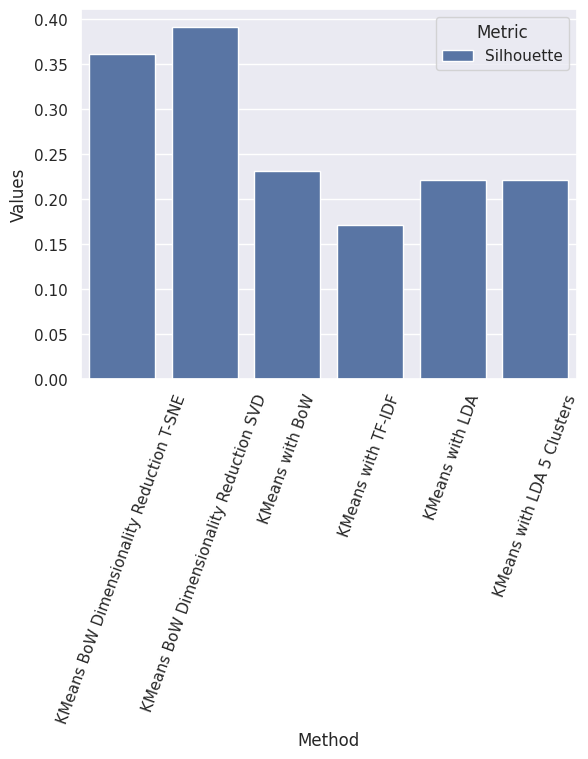

In [ ]:
clusteringEvaluation = pd.DataFrame({'Method': kmeans_titles,
                   'Values': kmeans_silhouette_scores,
                   'Metric': ['Silhouette']*len(kmeans_silhouette_scores)})
#set seaborn plotting aesthetics
sns.set(style='darkgrid')

sns.color_palette()

#create grouped bar chart
sns.barplot(x='Method', y='Values', hue='Metric', data=clusteringEvaluation) 
plt.xticks(rotation=70)


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'KMeans BoW Dimensionality Reduction T-SNE'),
  Text(1, 0, 'KMeans BoW Dimensionality Reduction SVD'),
  Text(2, 0, 'KMeans with BoW'),
  Text(3, 0, 'KMeans with TF-IDF'),
  Text(4, 0, 'KMeans with LDA'),
  Text(5, 0, 'KMeans with LDA 5 Clusters')])

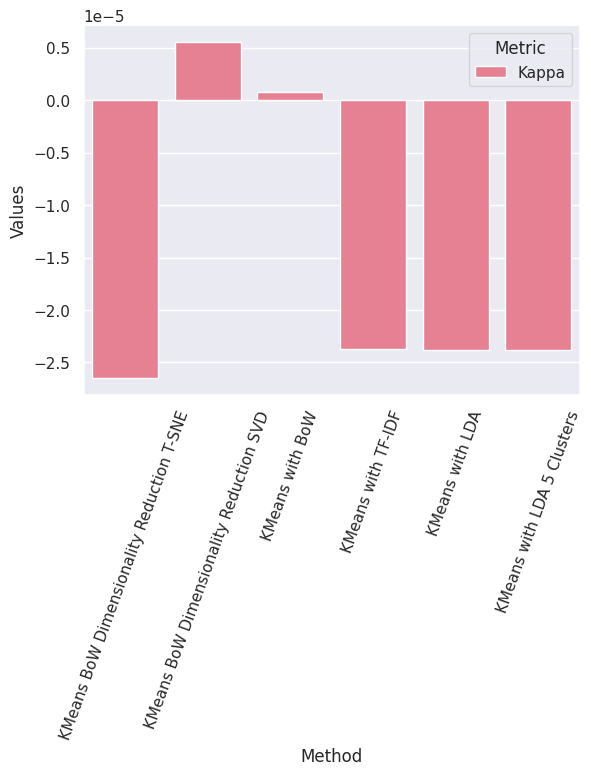

In [ ]:
clusteringEvaluation = pd.DataFrame({'Method': kmeans_titles,
                   'Values': kmeans_kappa_scores,
                   'Metric':  ['Kappa']*len(kmeans_kappa_scores)})
#set seaborn plotting aesthetics
sns.set(style='darkgrid')

#create grouped bar chart
sns.barplot(x='Method', y='Values', hue='Metric', data=clusteringEvaluation, palette="husl") 
plt.xticks(rotation=70)

In [ ]:
svd_kmeans_model, svd_features , svd_y_pred = kmeans_svd(8, X_bow_full_train, verbose=False)

Silhouette Score SVD: 0.3912244446290448
Kappa Score SVD: 5.5248749851743995e-06


# Item-based CF


## Without cluster labels 

In [ ]:
# Recomendation using only genre and vote_average
# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1 0.4]


new_x=[]
for x,y in zip(X_train_full["genre_hot_encoded"], X_train_full["vote_average"]):
    genres_votes=[]

    genres = x
    genres_votes.extend(genres)
    genres_votes.extend([round(float(y)/10,3)])
    new_x.append(genres_votes)

In [ ]:
print(new_x[1])

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0.58]


In [ ]:
corr_mat = np.corrcoef(new_x)
corr_mat.shape

(33849, 33849)

In [ ]:
X_train_full["original_title"].head()

0         Come Early Morning
1                    Keyhole
2                  Choose Me
3    The Cheerleader Murders
4                     Havana
Name: original_title, dtype: object

In [ ]:
X_train_full.columns

Index(['adult', 'budget', 'original_language', 'popularity', 'revenue',
       'vote_average', 'vote_count', 'original_title', 'overview', 'tagline',
       'genres_list', 'genre_hot_encoded', 'genres_list_encoded',
       'genres_list_tupled', 'text_concat', 'vote_average_categorical'],
      dtype='object')

In [ ]:
print(X_train_full[X_train_full["original_title"]=="The Dead Room"][["genres_list","vote_average","vote_count"]])
print(X_train_full[X_train_full["original_title"]=="Greystone Park"][["genres_list","vote_average","vote_count"]])

             genres_list  vote_average  vote_count
7104  [Horror, Thriller]           4.8          39
              genres_list  vote_average  vote_count
10650  [Horror, Thriller]           3.9          12


In [ ]:
tmp=pd.DataFrame({'corr_specific':corr_specific, 'Movies': X_train_full['original_title']})\
    .sort_values('corr_specific', ascending=False)\
    # .apply(lambda x: float(x['corr_specific'])>0.95)
display(tmp)

corr_specific                      Movies
16742       1.000000              The Shadow Men
19935       0.999982                  Road Train
19738       0.999982                 Ice Spiders
24988       0.999982                         DNA
4043        0.999928    Project Shadowchaser III
...              ...                         ...
32769      -0.258025                     小白龍情海翻波
4762       -0.282551                        홀리데이
1988       -0.286351  Jonah: A VeggieTales Movie
2722       -0.298312                  Crossroads
22428      -0.299613  MVP: Most Valuable Primate

[33849 rows x 2 columns]

In [ ]:
def recommendBasedOnMovie(MovieTitle, withBest=True):
  col_idx = X_train_full.index[X_train_full["original_title"]==MovieTitle].tolist()
  corr_specific = corr_mat[col_idx].T[:,0]
  # print(corr_specific.T.shape)

  tmp=pd.DataFrame({'corr_specific':corr_specific, 'Movies': X_train_full['original_title']})\
  .sort_values('corr_specific', ascending=False)\
  .head(50)\
  
  tmp = tmp.loc[(tmp['corr_specific']>0.95) & (tmp['corr_specific']!=1.0)]
  
  tmp2=pd.DataFrame()
  for i in tmp["Movies"].to_list():
    tmp2=tmp2.append(X_train_full[X_train_full["original_title"]==i][["genres_list","vote_average"]])
  
  display(X_train_full[X_train_full["original_title"]==MovieTitle][["original_title","genres_list","vote_average"]])

  movies_recommendations = pd.concat([tmp, tmp2], axis=1, join="inner")
  if(withBest):
    display(movies_recommendations\
            .sort_values('vote_average', ascending=False)\
            .head(10))
  else:
    display(movies_recommendations.head(10))

In [ ]:
recommendBasedOnMovie("The Shadow Men", withBest=False)

original_title                          genres_list  vote_average
16742  The Shadow Men  [Horror, Science Fiction, Thriller]           3.6

corr_specific                      Movies  \
19935       0.999982                  Road Train   
19738       0.999982                 Ice Spiders   
24988       0.999982                         DNA   
4043        0.999928    Project Shadowchaser III   
875         0.999928                   Tentacoli   
13183       0.999927                  The Cell 2   
24432       0.999927                  Lake Eerie   
17798       0.999838                Dead Shadows   
25572       0.999837  Ragin Cajun Redneck Gators   
2762        0.999713      It Conquered the World   

                               genres_list  vote_average  
19935  [Horror, Thriller, Science Fiction]           3.5  
19738  [Horror, Science Fiction, Thriller]           3.5  
24988  [Horror, Thriller, Science Fiction]           3.5  
4043   [Science Fiction, Horror, Thriller]           3.8  
875    [Thriller, Horror, Science Fiction]           3.8  
13183  [Horror, Science Fiction, Thriller]           3.4  
24432  [Thriller, Horror, Science Fiction]           3.4  
17798  [Horror, Science Fiction, Thriller]           3.9  
25572  [Horror, Thriller, Science Fiction]           3.3  
2762   [Horror, Science Fiction, Thriller]           4.0

In [ ]:
recommendBasedOnMovie("The Shadow Men")

original_title                          genres_list  vote_average
16742  The Shadow Men  [Horror, Science Fiction, Thriller]           3.6

corr_specific                        Movies  \
25621       0.996049                      The Thaw   
84          0.996049                   Containment   
26587       0.996049             2 Lava 2 Lantula!   
9202        0.996551                     Apollo 18   
7869        0.996551          Ghost in the Machine   
8744        0.996551                The Dark Tapes   
4717        0.996551          The Phoenix Incident   
17494       0.996551  The Killings at Outpost Zeta   
27653       0.997019                    Altergeist   
11697       0.997019   The Brain from Planet Arous   

                               genres_list  vote_average  
25621  [Horror, Science Fiction, Thriller]           5.1  
84     [Thriller, Horror, Science Fiction]           5.1  
26587  [Horror, Science Fiction, Thriller]           5.1  
9202   [Horror, Thriller, Science Fiction]           5.0  
7869   [Horror, Science Fiction, Thriller]           5.0  
8744   [Horror, Science Fiction, Thriller]           5.0  
4717   [Horror, Thriller, Science Fiction]           5.0  
17494  [Horror, Science Fiction, Thriller]           5.0  
27653  [Thriller, Horror, Science Fiction]           4.9  
11697  [Horror, Science Fiction, Thriller]           4.9

In [ ]:
recommendBasedOnMovie("The Matrix")

original_title                genres_list  vote_average
15275     The Matrix  [Action, Science Fiction]           7.9

corr_specific                       Movies                genres_list  \
15740       0.999983  Sting of the Black Scorpion  [Action, Science Fiction]   
17692       0.999566                        Rakka  [Action, Science Fiction]   
13280       0.999371               Virtual Combat  [Science Fiction, Action]   
30264       0.998561            Portal: No Escape  [Action, Science Fiction]   
764         0.997827                       Avalon  [Action, Science Fiction]   
18621       0.997400                     I, Robot  [Action, Science Fiction]   
28080       0.996932                 Flash Gordon  [Action, Science Fiction]   
30468       0.996932                The Challenge  [Action, Science Fiction]   
15747       0.996932                        Dredd  [Action, Science Fiction]   
10652       0.995872     I predatori di Atlantide  [Action, Science Fiction]   

       vote_average  
15740           8.0  
17692           7.4  
13280           7.3  
30264           7.0  
764             6.8  
18621           6.7  
28080           6.6  
30468           6.6  
15747           6.6  
10652           6.4

In [ ]:
recommendBasedOnMovie("Toy Story")

original_title                  genres_list  vote_average
32344      Toy Story  [Animation, Comedy, Family]           7.7

corr_specific                      Movies                  genres_list  \
27693       0.999986          One Froggy Evening  [Animation, Comedy, Family]   
24034       0.999986                 Rabbit Fire  [Animation, Family, Comedy]   
7802        0.999986          The Wrong Trousers  [Animation, Comedy, Family]   
15372       0.999942              Monsters, Inc.  [Animation, Comedy, Family]   
25737       0.999942                 Жил-был пёс  [Animation, Comedy, Family]   
30887       0.999768        Toy Story of Terror!  [Animation, Comedy, Family]   
4433        0.999768      Scooby-Doo! Camp Scare  [Animation, Comedy, Family]   
16437       0.999768           Creature Comforts  [Animation, Comedy, Family]   
2765        0.999768                 Toy Story 2  [Animation, Comedy, Family]   
17540       0.999636  A Matter of Loaf and Death  [Animation, Comedy, Family]   

       vote_average  
27693           7.8  
24034           7.6  
7802            7.6  
15372           7.5  
25737           7.5  
30887           7.3  
4433            7.3  
16437           7.3  
2765            7.3  
17540           7.2

## With Prior-Knowledge-Input (cluster labels)

In [ ]:
# Recomendation using only genre and vote_average
# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 4]

clusters_labels = svd_kmeans_model.predict(svd_features)

new_x_clusters=[]
for x,y,z in zip(X_train_full["genre_hot_encoded"], X_train_full["vote_average"], clusters_labels):
    genres_votes_clusters=[]

    genres = x
    vote = y
    clusterLabel = z
    genres_votes_clusters.extend(genres)
    genres_votes_clusters.extend([round(float(vote)/10,3)])
    genres_votes_clusters.append(clusterLabel+1)
    new_x_clusters.append(genres_votes_clusters)

In [ ]:
print(new_x_clusters[1])

[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0.58, 3]


In [ ]:
corr_mat_clusters = np.corrcoef(new_x_clusters)
corr_mat_clusters.shape

(33849, 33849)

In [ ]:
def recommendBasedOnMovieAndCluster(MovieTitle):
  col_idx = X_train_full.index[X_train_full["original_title"]==MovieTitle].tolist()
  corr_specific = corr_mat_clusters[col_idx].T[:,0]

  tmp=pd.DataFrame({'corr_specific':corr_specific, 'Movies': X_train_full['original_title']})\
  .sort_values('corr_specific', ascending=False)\
  .head(50)

  tmp = tmp.loc[(tmp['corr_specific']>0.95) & (tmp['corr_specific']!=1.0)]
  
  display(X_train_full[X_train_full["original_title"]==MovieTitle][["original_title","genres_list","vote_average"]])
  
  
  tmp2=pd.DataFrame()
  for i in tmp["Movies"].to_list():
    tmp2=tmp2.append(X_train_full[X_train_full["original_title"]==i][["genres_list","vote_average"]])
  
  recommendations = pd.concat([tmp, tmp2], axis=1, join="inner")\
          .sort_values('vote_average', ascending=False)\
          .head(10)
  recommendations["PKI"] = clusters_labels[list(recommendations.index)]

  display(recommendations)


In [ ]:
recommendBasedOnMovieAndCluster("The Shadow Men")

original_title                          genres_list  vote_average
16742  The Shadow Men  [Horror, Science Fiction, Thriller]           3.6

corr_specific                             Movies  \
394         0.995228  Der Golem, wie er in die Welt kam   
30670       0.997504                      The Dead Zone   
1251        0.992545              The War of the Worlds   
1318        0.995372                           The Mist   
20359       0.995416                          The Brood   
29794       0.992650     X: The Man with the X-Ray Eyes   
7592        0.995571                           The Fury   
21380       0.998709        The Man They Could Not Hang   
30382       0.992712            The Day of the Triffids   
29996       0.994618                      Night Shadows   

                               genres_list  vote_average  PKI  
394    [Horror, Science Fiction, Thriller]           7.0    6  
30670  [Horror, Science Fiction, Thriller]           6.9    5  
1251   [Horror, Science Fiction, Thriller]           6.8    7  
1318   [Science Fiction, Horror, Thriller]           6.7    6  
20359  [Horror, Science Fiction, Thriller]           6.6    6  
29794  [Horror, Science Fiction, Thriller]           6.4    7  
7592   [Horror, Science Fiction, Thriller]           6.2    6  
21380  [Horror, Science Fiction, Thriller]           6.2    4  
30382  [Horror, Science Fiction, Thriller]           6.1    7  
29996  [Horror, Science Fiction, Thriller]           6.1    3

In [ ]:
recommendBasedOnMovieAndCluster("The Matrix")

original_title                genres_list  vote_average
15275     The Matrix  [Action, Science Fiction]           7.9

corr_specific                                        Movies  \
18422       0.989932                       The Empire Strikes Back   
19654       0.989919                    Iria: Zeiram the Animation   
15740       0.999999                   Sting of the Black Scorpion   
21706       0.989899                            GHOST IN THE SHELL   
13538       0.991501           Captain America: The Winter Soldier   
6872        0.989907                                         Taken   
16460       0.989905                           V: The Final Battle   
32451       0.989901                                  The Sea Hawk   
22578       0.991344  Star Wars: Episode III - Revenge of the Sith   
7307        0.989887                                  The Defector   

                                genres_list  vote_average  PKI  
18422  [Adventure, Action, Science Fiction]           8.2    6  
19654  [Action, Animation, Science Fiction]           8.0    6  
15740             [Action, Science Fiction]           8.0    6  
21706  [Action, Animation, Science Fiction]           7.8    6  
13538  [Action, Adventure, Science Fiction]           7.6    7  
6872                      [Science Fiction]           7.4    6  
16460                     [Science Fiction]           7.3    6  
32451                              [Action]           7.2    6  
22578  [Science Fiction, Adventure, Action]           7.1    7  
7307                               [Action]           7.0    6

In [ ]:
recommendBasedOnMovieAndCluster("Toy Story")

original_title                  genres_list  vote_average
32344      Toy Story  [Animation, Comedy, Family]           7.7

corr_specific                    Movies                  genres_list  \
27693       0.992208        One Froggy Evening  [Animation, Comedy, Family]   
32344       1.000000                 Toy Story  [Animation, Comedy, Family]   
24034       0.999996               Rabbit Fire  [Animation, Family, Comedy]   
4433        0.999929    Scooby-Doo! Camp Scare  [Animation, Comedy, Family]   
16437       0.999929         Creature Comforts  [Animation, Comedy, Family]   
32219       0.999839          Rabbit Seasoning  [Animation, Family, Comedy]   
4186        0.999781  Joulupukki ja noitarumpu  [Comedy, Animation, Family]   
22444       0.999781          Боцман и попугай  [Animation, Comedy, Family]   
20549       0.999781  Minions: Orientation Day  [Animation, Comedy, Family]   
22790       0.999714     Dug's Special Mission  [Animation, Comedy, Family]   

       vote_average  PKI  
27693           7.8    3  
32344           7.7    2  
24034           7.6    2  
4433            7.3    2  
16437           7.3    2  
32219           7.1    2  
4186            7.0    2  
22444           7.0    2  
20549           7.0    2  
22790           6.9    2

In [ ]:
recommendBasedOnMovieAndCluster("Keyhole")

original_title                genres_list  vote_average
1        Keyhole  [Drama, Action, Thriller]           5.8

corr_specific                          Movies  \
1217        0.999235                 Vanishing Point   
33052       0.999347                    Crimson Tide   
24694       0.999451                        Daglicht   
9684        0.999451                        அந்நியன்   
22715       0.999546                    Black Sunday   
24959       0.999546                          무방비 도시   
24341       0.999632                      מבצע יונתן   
15220       0.999709                  Romper Stomper   
5792        0.999777  Windkracht 10: Koksijde Rescue   
14989       0.999777                  A Erva do Rato   

                     genres_list  vote_average  PKI  
1217   [Action, Thriller, Drama]           7.1    2  
33052  [Action, Thriller, Drama]           7.0    2  
24694  [Drama, Action, Thriller]           6.9    2  
9684   [Action, Drama, Thriller]           6.9    2  
22715  [Action, Drama, Thriller]           6.8    2  
24959  [Thriller, Drama, Action]           6.8    2  
24341  [Action, Drama, Thriller]           6.7    2  
15220  [Action, Drama, Thriller]           6.6    2  
5792   [Drama, Action, Thriller]           6.5    2  
14989  [Drama, Action, Thriller]           6.5    2

## Conditional generation based on genre 

In [ ]:
genre_mapping = dict(zip(enc.classes_, enc.transform(enc.classes_)))
print(genre_mapping)

{'Action': 0, 'Adventure': 1, 'Animation': 2, 'Comedy': 3, 'Crime': 4, 'Documentary': 5, 'Drama': 6, 'Family': 7, 'Fantasy': 8, 'Foreign': 9, 'History': 10, 'Horror': 11, 'Music': 12, 'Mystery': 13, 'Romance': 14, 'Science Fiction': 15, 'TV Movie': 16, 'Thriller': 17, 'War': 18, 'Western': 19}


In [ ]:
# Recomendation using only genre and vote_average
# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 4]

# After this it should be if the user wants "Action" related recommendation we ill weigh index i
# [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 1, 1, 4]

def recommendBasedOnMovieAndGenre(MovieTitle, Genre):
    genreIndex = genre_mapping[Genre]

    new_x_clusters_tmp = np.array(new_x_clusters)
    new_x_clusters_tmp[:,genreIndex] *= 3

    corr_mat_clusters_tmp = np.corrcoef(new_x_clusters_tmp)
    
    col_idx = X_train_full.index[X_train_full["original_title"]==MovieTitle].tolist()
    corr_specific = corr_mat_clusters_tmp[col_idx].T[:,0]

    # to avoid memory leaks and memory consumption
    del new_x_clusters_tmp
    del corr_mat_clusters_tmp

    tmp=pd.DataFrame({'corr_specific':corr_specific, 'Movies': X_train_full['original_title']})\
    .sort_values('corr_specific', ascending=False)\
    .head(50)

    tmp = tmp.loc[(tmp['corr_specific']!=1.0) & (tmp['corr_specific']>0.95)]

    display(X_train_full[X_train_full["original_title"]==MovieTitle][["original_title","genres_list","vote_average"]])

    tmp2=pd.DataFrame()
    for i in tmp["Movies"].to_list():
        tmp2=tmp2.append(X_train_full[X_train_full["original_title"]==i][["genres_list","vote_average"]])

    recommendations = pd.concat([tmp, tmp2], axis=1, join="inner")\
          .sort_values('vote_average', ascending=False)\
          .head(10)
    recommendations["PKI"] = clusters_labels[list(recommendations.index)]

    display(recommendations)


In [ ]:
recommendBasedOnMovieAndGenre("The Matrix", "Action")

original_title                genres_list  vote_average
30554     The Matrix  [Action, Science Fiction]           7.9

corr_specific                         Movies  \
23276       0.992901        The Empire Strikes Back   
6684        0.992893     Iria: Zeiram the Animation   
8238        0.992896  She hao dan xin zhen jiu zhou   
14618       0.992887        Guardians of the Galaxy   
17457       0.992887             Return of the Jedi   
31748       0.992834                   The Avengers   
11836       0.992834                 The Terminator   
12762       0.992804               Forbidden Planet   
3573        0.992914                   The Sea Hawk   
29428       0.992904                    The Bat Man   

                                genres_list  vote_average  PKI  
23276  [Adventure, Action, Science Fiction]           8.2    7  
6684   [Action, Animation, Science Fiction]           8.0    7  
8238                               [Action]           8.0    7  
14618  [Action, Science Fiction, Adventure]           7.9    7  
17457  [Adventure, Action, Science Fiction]           7.9    7  
31748  [Science Fiction, Action, Adventure]           7.4    7  
11836   [Action, Thriller, Science Fiction]           7.4    7  
12762  [Adventure, Science Fiction, Action]           7.2    7  
3573                               [Action]           7.2    7  
29428                              [Action]           7.0    7

In [ ]:
recommendBasedOnMovieAndGenre("Toy Story", "Comedy")

original_title                  genres_list  vote_average
17828      Toy Story  [Animation, Comedy, Family]           7.7

corr_specific                           Movies  \
4112        0.984796                   In a Heartbeat   
13762       0.984781              Flåklypa Grand Prix   
28806       0.993383               One Froggy Evening   
24321       0.999998                      Rabbit Fire   
14287       0.999986                Broom-Stick Bunny   
3078        0.984774                 Air Raid Wardens   
28698       0.984774                       Fresh Hare   
14415       0.999976           Scooby-Doo! Camp Scare   
8646        0.999976                Creature Comforts   
6905        0.996165  How the Grinch Stole Christmas!   

                                  genres_list  vote_average  PKI  
4112     [Family, Animation, Romance, Comedy]           8.3    4  
13762  [Animation, Family, Adventure, Comedy]           7.9    4  
28806             [Animation, Comedy, Family]           7.8    3  
24321             [Animation, Family, Comedy]           7.6    4  
14287             [Animation, Family, Comedy]           7.4    4  
3078                         [Comedy, Family]           7.3    4  
28698                     [Comedy, Animation]           7.3    4  
14415             [Animation, Comedy, Family]           7.3    4  
8646              [Animation, Comedy, Family]           7.3    4  
6905              [Animation, Family, Comedy]           7.2    5

# Userbased Collaborative Filtering



In [ ]:
userRatings= pd.read_csv("/home/azureuser/cloudfiles/code/Users/amoha452/ratings_small.csv")

In [ ]:
userRatings.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [ ]:
userRatings = userRatings.drop(['timestamp'], axis=1)
userRatings.rename(columns={'userId': 'userID', 'movieId': 'itemID'}, inplace=True)

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(userRatings[['userID', 'itemID', 'rating']], reader)

In [ ]:
data

In [ ]:
df= pd.read_csv("/home/azureuser/cloudfiles/code/Users/amoha452/"+movies_metadata , usecols=["id", "original_title","genres","vote_average"])
links= pd.read_csv("/home/azureuser/cloudfiles/code/Users/amoha452/links.csv",usecols=["movieId"])

In [ ]:
final_genre_list=[]
for i in df["genres"]:
    tmp=[]
    for j in eval(i):
        tmp.append(j["name"])
    final_genre_list.append(tmp)
df["genres"] = final_genre_list
df["id"]=links["movieId"]
df.rename(columns={"genres":"genres_list"}, inplace=True)

In [ ]:
trainset = data.build_full_trainset() 
algo = SVDpp()
algo.fit(trainset)
testset = trainset.build_anti_testset()

predictions = algo.test(testset)

In [ ]:
def get_all_predictions(predictions, topN, user_id):
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:topN]
    tmp = pd.DataFrame.from_dict(top_n)
    tmp_transpose = tmp.transpose()
    
    results = tmp_transpose.loc[user_id]
    recommended_movie_ids=[]
    for x in range(0, topN):
        recommended_movie_ids.append(results[x][0])
    movies_recommended = df[df["id"].isin(recommended_movie_ids)].loc[:,["original_title","genres_list"]]
    
    return movies_recommended


In [ ]:
userID = 1
topN = 5
recommendations=get_all_predictions(predictions, topN, userID)
recommendations

original_title                      genres_list
315           Shallow Grave                [Crime, Thriller]
843             Kansas City  [Thriller, Drama, Music, Crime]
888                 Sabrina         [Comedy, Drama, Romance]
952       Huang jia shi jie                [Action, Foreign]
2832  From Russia with Love    [Action, Thriller, Adventure]

In [ ]:
userXRatings = userRatings[userRatings["userID"]==userID].sort_values("rating", ascending = False)
original_ratings =df[df["id"].isin(userXRatings["itemID"])].loc[:,["original_title","genres_list"]]
original_ratings

original_title  \
30                                      Dangerous Minds   
1010                                Synthetic Pleasures   
1041                                     For the Moment   
1106             The Line King: The Al Hirschfeld Story   
1149                                            ¡Átame!   
1235                                            大红灯笼高高挂   
1259                                       Paris, Texas   
1265                                 Santa with Muscles   
1309                                              Shine   
1313  Paradise Lost: The Child Murders at Robin Hood...   
1340                                           Jaws 3-D   
1372                                   Fierce Creatures   
1870               Friday the 13th Part VI: Jason Lives   
2022                                        Höstsonaten   
2067                                               Rope   
2110                                            Murder!   
2210                                         The Cruise   
2371                                         Tinseltown   
2883                                 Man Of The Century   
3581                                          Mad Max 2   

                                         genres_list  
30                                    [Drama, Crime]  
1010                                   [Documentary]  
1041                   [War, Drama, Romance, Action]  
1106                                   [Documentary]  
1149                 [Comedy, Crime, Drama, Romance]  
1235                                         [Drama]  
1259                                         [Drama]  
1265                                [Family, Comedy]  
1309                                         [Drama]  
1313                            [Documentary, Drama]  
1340                              [Thriller, Horror]  
1372                               [Comedy, Romance]  
1870                     [Horror, Mystery, Thriller]  
2022                                  [Music, Drama]  
2067               [Crime, Drama, Mystery, Thriller]  
2110                             [Mystery, Thriller]  
2210                                   [Documentary]  
2371                                              []  
2883                               [Romance, Comedy]  
3581  [Adventure, Action, Thriller, Science Fiction]